# Analysis of k-mer JS & ANI between all 151 Mtb genomes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline


In [2]:
import screed

In [3]:
import mmh3

In [4]:
# https://github.com/ipython/ipython/issues/10627
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

In [5]:

import ete3 as ETE

from ete3 import Tree

### Set matplotlib text export settings for Adobe Illustrator

In [6]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Define paths to sample metadata files

In [7]:
Repo_DataDir = "../../Data"
InputAsmPath_Dir = f"{Repo_DataDir}/231121.InputAsmTSVs.MtbSetV3.151CI"

MtbSetV3_151CI_InputAsmPATHs_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAndSRAsm.FAPATHs.V1.tsv"

MtbSetV3_151CI_AsmSumm_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAsm.AsmSummary.V2.tsv"


## PARSE METADATA FOR ALL assemblies processed by this pipeline

In [8]:
WGA158CI_LRandSR_Asm_Path_DF = pd.read_csv(MtbSetV3_151CI_InputAsmPATHs_TSV, sep = "\t")

WGA158CI_LRandSR_Asm_Path_DF.columns = ['SampleID', 'Dataset_Tag',
                                        'Genome_LR_ASM_PATH', 'Genome_SR_ASM_PATH']


In [9]:
WGA158CI_LRandSR_Asm_Path_DF.head(1)

,SampleID,Dataset_Tag,Genome_LR_ASM_PATH,Genome_SR_ASM_PATH
0,N0072,ChinerOms_2019,/n/data1/hms/dbmi/farhat/mm774/Projects/231121...,/n/data1/hms/dbmi/farhat/mm774/Projects/231121...


## Parse sample Metadata (N = 151)

In [10]:

WGA151CI_AsmSummary_DF = pd.read_csv(MtbSetV3_151CI_AsmSumm_TSV, sep = "\t")

SampleIDs_151CI_SOI = list( WGA151CI_AsmSummary_DF["SampleID"].values )
WGA151CI_SampleIDs = SampleIDs_151CI_SOI

#print(','.join(SampleIDs_151CI_SOI) )

ID_To_PrimLineage_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'PrimaryLineage']].values)
ID_To_SubLineage_Dict = dict( WGA151CI_AsmSummary_DF[["SampleID", "Lineage"]].values)
ID_To_Dataset_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'Dataset_Tag']].values)
WGA151CI_AsmSummary_DF.shape

(151, 7)

In [11]:
WGA151CI_AsmSummary_DF.head(3)

,SampleID,numContigs_Complete,Flye_CircContig_Cov,PrimaryLineage,Lineage,Dataset_Tag,AsmApproach
0,N0072,1,358,lineage1,"lineage1,lineage1.1,lineage1.1.2",ChinerOms_2019,PBrs2_LR_Flye_I3_SR_Pilon
1,N0153,1,372,lineage1,"lineage1,lineage1.1,lineage1.1.1,lineage1.1.1.1",ChinerOms_2019,PBrs2_LR_Flye_I3_SR_Pilon
2,TB3113,1,933,lineage2,"lineage2,lineage2.2,lineage2.2.1",TB_Portals_24CI_R1,PBrs2_LR_Flye_I3_SR_Pilon


# Define output dir of the Mtb-WGA-SMK processing pipeline

In [12]:
# Define pipeline output directories

WGA_SMK_Outputs_Dir = "/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output"

WGA151CI_SMK_OutputDir = WGA_SMK_Outputs_Dir + "/231121_MtbSetV3_151CI"

MtbWGA_SMK_Pipeline_OutputDir = WGA151CI_SMK_OutputDir


In [13]:
!ls -alh $WGA_SMK_Outputs_Dir

total 352K
drwxrwsr-x 11 mm774 farhat  402 Nov 22 01:55 .
drwxrwsr-x 38 mm774 farhat 2.1K Nov 30 22:08 ..
drwxrwsr-x  2 mm774 farhat    0 Sep 20  2022 220415_WGA48CI_PB_V1
drwxrwsr-x  6 mm774 farhat  122 Jul 20  2022 220427_WGA158CI_V1
drwxrwsr-x  2 mm774 farhat    0 Jul 20  2022 220605_MTBC_TestPhyloSMK_V1
drwxrwsr-x 18 mm774 farhat  550 Jun 19  2023 220720_WGA158CI_V2
drwxrwsr-x  6 mm774 farhat  125 Feb 15  2023 220720_WGA158CI_V3_SRPangenomeRerun
drwxrwsr-x  6 mm774 farhat  125 Feb 18  2023 220720_WGA158CI_V4_Unicycler48WiKrakFilt_SRPangenomeRerun
drwxrwsr-x  9 mm774 farhat  225 May 30  2023 230530_TBP22_22CI_V1
drwxrwsr-x  6 mm774 farhat  127 Nov 26 00:15 230918_MtbSetV2_136CI_V1
drwxrwsr-x 15 mm774 farhat  405 Dec 29 01:01 231121_MtbSetV3_151CI


In [14]:
!ls -1 $MtbWGA_SMK_Pipeline_OutputDir

AsmAnalysis
Asm_MergeSNPs_mpileup
Asm_MergeVar_mpileup
Busco_Download_Tmp
FastANI
HomologyMapping
Minigraph
NucDiversity
O2logs
PanGenome_Analysis
Phylogenies
RecombDetection
SourMash


## Parse IQ-Tree phylogeny

In [15]:
Phylos_OutDir = f"{MtbWGA_SMK_Pipeline_OutputDir}/Phylogenies"

IQ_10AmbFilt_PhyloOutDir = f"{Phylos_OutDir}/iqtree_mpileupSNVs_10AmbFilt"
IQ_Tree_10Amb_Filt_PATH = f"{IQ_10AmbFilt_PhyloOutDir}/IQtree.10AmbThresh.NoMask.MidRoot.WiNodeNames.newick"    


IQ_PLCFilt_PhyloOutDir = f"{Phylos_OutDir}/iqtree_mpileupSNVs_PLCFilt"
IQ_Tree_10Amb_PLC_Filt_PATH = f"{IQ_PLCFilt_PhyloOutDir}/IQtree.10AmbThresh.PLCMask.MidRoot.WiNodeNames.newick"    


## Parse Phylogenies

In [16]:
IQ_Tree = Tree(IQ_Tree_10Amb_PLC_Filt_PATH, format = 1)

T_RootPoint = IQ_Tree.get_leaves_by_name("RW-TB008")[0]    
IQ_Tree.set_outgroup(T_RootPoint)

In [17]:
# Count the number of nodes after midpoint rooting
num_nodes = len(IQ_Tree.get_leaves()) + len([node for node in IQ_Tree.traverse() if not node.is_leaf()])

print(num_nodes)

301


### Add lineage info to tree and sort by sub-lineage

In [18]:
count = 0
for n in IQ_Tree.get_leaves():

    if "Bakta" in n.name:
        n.name = n.name.split(".")[0]
    
    n.add_feature("Primary_lineage", ID_To_PrimLineage_Dict.get(n.name, "Unknown Lineage") )
    n.add_feature("Sublineage", ID_To_SubLineage_Dict.get(n.name, "Unknown Lineage") )
    #print("node:", n.name, " Lineage:", n.Mtb_lineage)
    count +=1

print(count)  
IQ_Tree.sort_descendants(attr='Primary_lineage')
IQ_Tree.sort_descendants(attr='Sublineage')

151


## Parsing over each node of the tree (ETE3) and infer lineage

In [19]:
IQ_node_To_PrimaryLin_Dict = {}

for node in IQ_Tree.iter_descendants("postorder"):
    # Do some analysis on node
    
    #print(node.name)
    listOf_ChildLineages = []
    
    for child_node in node.get_descendants():
        if child_node.is_leaf():
            listOf_ChildLineages.append(  (child_node.Primary_lineage) )
        
        #print(node.name, listOf_ChildLineages)
        
    set_Of_ChildLineages = list(set(listOf_ChildLineages))

    #print(node.name, set_Of_ChildLineages  )
    
    if len(set_Of_ChildLineages) == 1:
        OnlyOneLineage = True
    else:
        OnlyOneLineage = False
    
    if OnlyOneLineage:
        IQ_node_To_PrimaryLin_Dict[node.name] = set_Of_ChildLineages[0]
    
    #print(listOf_ChildLineages, set_Of_ChildLineages)
    #if node.name == "internal_90": break

    #if OnlyOneLineage: print(node.name, set_Of_ChildLineages )

IQ_node_To_PrimaryLin_Dict.update(ID_To_PrimLineage_Dict)
    

In [20]:
child_node.name

'mada_2-53'

In [21]:
child_node.Primary_lineage

'lineage4'

## Output "node_To_PrimaryLin_Dict" dictionary 

In [22]:
import json 

IQ_NodeToPriLineage_Dict_JSON = f"{IQ_PLCFilt_PhyloOutDir}/IQTree.NodeToPrimaryLineage.json"

with open(IQ_NodeToPriLineage_Dict_JSON, 'w') as json_file:
    json.dump(IQ_node_To_PrimaryLin_Dict, json_file)


#### test reading back in the JSON

In [23]:
with open(IQ_NodeToPriLineage_Dict_JSON) as json_file:
    IQ_node_To_PrimaryLin_Dict = json.load(json_file)

In [24]:
len(list(IQ_node_To_PrimaryLin_Dict.keys()))

295

## Plot phylogeny

In [25]:
# Dictionary for lineage to color mapping
LinToColor_Dict_OLD = {
    "lineage1": "#DF83AC",
    "lineage2": "#7098CB",
    "lineage3": "#815D9F",
    "lineage4": "#E76956",
    "lineage5": "#B67548",
    "lineage6": "#6AB79E",
    "lineage8": "#E4515B",
    "None": "black",
}

LinToColor_Dict = {
    "lineage1": "#D93467", 
    "lineage2": "#4FB2C0", 
    "lineage3": "#874391", 
    "lineage4": "#E16D3B", 
    "lineage5": "#95522E", 
    "lineage6": "#429688", 
    "lineage8": "#DB4144", 
    "None": "black",
}

# Extracting the mapping between IsolateID and PrimaryLineage_Ill
lineage_mapping = WGA151CI_AsmSummary_DF.set_index('SampleID')['PrimaryLineage'].to_dict()

# Creating a color mapping for the samples
sample_colors = {sample: LinToColor_Dict.get(lineage, "black") for sample, lineage in lineage_mapping.items()}


### Link to ETE3 documentation for tree layout style
 http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html#interactive-visualization-of-trees

In [26]:

def Mtb_ColorBranchByLineage_Layout_IQ(node):
    F = ETE.TextFace(node.name, fsize=2)
    if node.is_leaf():
        #NameAnd_Lineage_Text =  f"  {node.name} {node.Mtb_lineage}"
        #F_NameAndLineage = ETE.TextFace(NameAnd_Lineage_Text, fsize=3)
        
        #ETE.add_face_to_node(F_NameAndLineage, node, column=0, position="branch-right")

        
        nstyle = ETE.NodeStyle() # http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html#node-style
        nstyle["fgcolor"] = "black"
        nstyle["size"] = 1
        
        Node_PrimaryLin = IQ_node_To_PrimaryLin_Dict.get(node.name, "None")
        
        nstyle["vt_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
        nstyle["hz_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
          
        node.set_style(nstyle)
        node.margin_left = 10        
    else: 
        nstyle = ETE.NodeStyle() # http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html#node-style
        nstyle["fgcolor"] = "black"
        nstyle["size"] = 0
        
        Node_PrimaryLin = IQ_node_To_PrimaryLin_Dict.get(node.name, "None")
        
        nstyle["vt_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
        nstyle["hz_line_color"] = LinToColor_Dict.get(Node_PrimaryLin, "Black")
        
        node.set_style(nstyle)


ts_1 = ETE.TreeStyle()
ts_1.show_leaf_name = False
ts_1.show_branch_length = False
ts_1.show_branch_support = False
ts_1.show_scale = False #True
#ts_1.branch_vertical_margin = 2
ts_1.layout_fn = Mtb_ColorBranchByLineage_Layout_IQ
ts_1.rotation = 90


ts_IQ_circ = ETE.TreeStyle()
ts_IQ_circ.mode = "c" # draw tree in circular mode
ts_IQ_circ.arc_start = 0 #-180 # 0 degrees = 3 o'clock
ts_IQ_circ.arc_span = 180
ts_IQ_circ.show_leaf_name = False
ts_IQ_circ.show_branch_length = False
ts_IQ_circ.show_branch_support = False
ts_IQ_circ.show_scale = True #True
ts_IQ_circ.branch_vertical_margin = 2
ts_IQ_circ.layout_fn = Mtb_ColorBranchByLineage_Layout_IQ

ts_IQ = ETE.TreeStyle()
ts_IQ.show_leaf_name = False
ts_IQ.show_branch_length = False
ts_IQ.show_branch_support = False
ts_IQ.show_scale = True #True
ts_IQ.branch_vertical_margin = 2
ts_IQ.layout_fn = Mtb_ColorBranchByLineage_Layout_IQ
ts_IQ.rotation = 90
ts_IQ.scale_length = 0.002


ts_IQ_WiName = ETE.TreeStyle()
ts_IQ_WiName.show_leaf_name = True
ts_IQ_WiName.show_branch_length = False
ts_IQ_WiName.show_branch_support = False
ts_IQ_WiName.show_scale = False #True
ts_IQ_WiName.branch_vertical_margin = 2
ts_IQ_WiName.layout_fn = Mtb_ColorBranchByLineage_Layout_IQ
ts_IQ_WiName.rotation = 0
ts_IQ_WiName.scale_length = 0.02


## Visualize Mtb-151CI Phylogeny

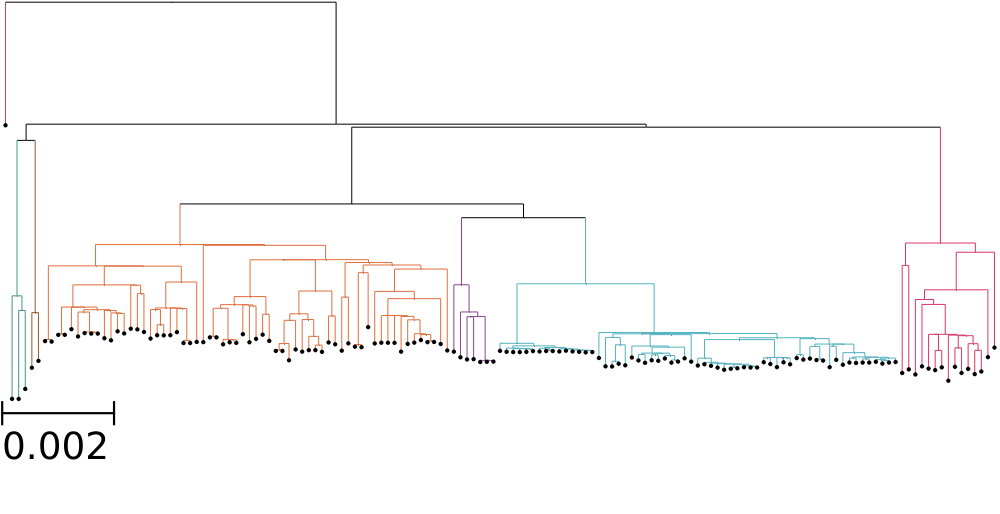

In [27]:
IQ_Tree.render("%%inline", w = 1000, tree_style = ts_IQ)

In [28]:
!mkdir Results1_Plots/

mkdir: cannot create directory ‘Results1_Plots/’: File exists


In [29]:
Z = IQ_Tree.render("Results1_Plots/1.Mtb.151CI.RectPhylo.png", w = 1000, tree_style = ts_IQ)     

In [30]:
Z = IQ_Tree.render("Results1_Plots/1.Mtb.151CI.RectPhylo.svg", w = 1000, tree_style = ts_IQ)    

In [31]:
OrderOfSampleIDs_Phylo = [ n.name for n in IQ_Tree.get_leaves() ]  

In [32]:
print(OrderOfSampleIDs_Phylo)

['N0153', 'N0072', 'mada_2-46', 'mada_1-44', 'mada_107', 'mada_1-1', 'mada_1-51', 'mada_1-39', 'mada_1-36', 'mada_117', 'mada_122', 'mada_118', 'mada_1-10', 'R27252', 'R23887', 'TB3091', '9050-05', '3003-06', '702-06', '696-05', '8651-04', 'TB3396', '4549-04', 'TB1612', 'TB2780', 'TB3368', 'TB1236', 'TB2659', '8129-04', 'R30215', 'R25048', 'TB2512', 'TB2981', 'TB2995', 'TB3113', '706-05', 'R30078', 'R28012', 'R27657', 'R30234', 'R31095', 'R28703', 'R24120', 'R36431', 'R29816', 'S0070-08', 'N0155', 'N0145', 'R29598', 'R24100', 'S0107-01', 'R28581', 'S0256-08', 'S0085-01', 'S0089-01', 'mada_1-11', 'M0003941_3', 'mada_115', 'mada_2-42', 'R37765', '18_0621851', 'R22601', 'R27937', 'R18040', 'R18043', 'R27725', 'R26791', 'R20574', 'R20260', 'R21408', 'R23146', 'R28980', 'R32929', 'R26778', 'R30420', 'R21893', 'QC-9', 'QC-5', 'QC-3', 'N0004', 'mada_1-30', 'N0054', 'N1274', '01_R1134', 'TB2968', 'mada_1-53', 'mada_2-53', 'mada_1-50', 'mada_2-1', 'R23571', 'mada_123', 'mada_1-12', 'mada_1-15',

In [33]:
OrderOfSampleIDs_Phylo[:2]

['N0153', 'N0072']

In [34]:
OrderOfSampleIDs_Phylo[-2:]

['N1177', 'RW-TB008']

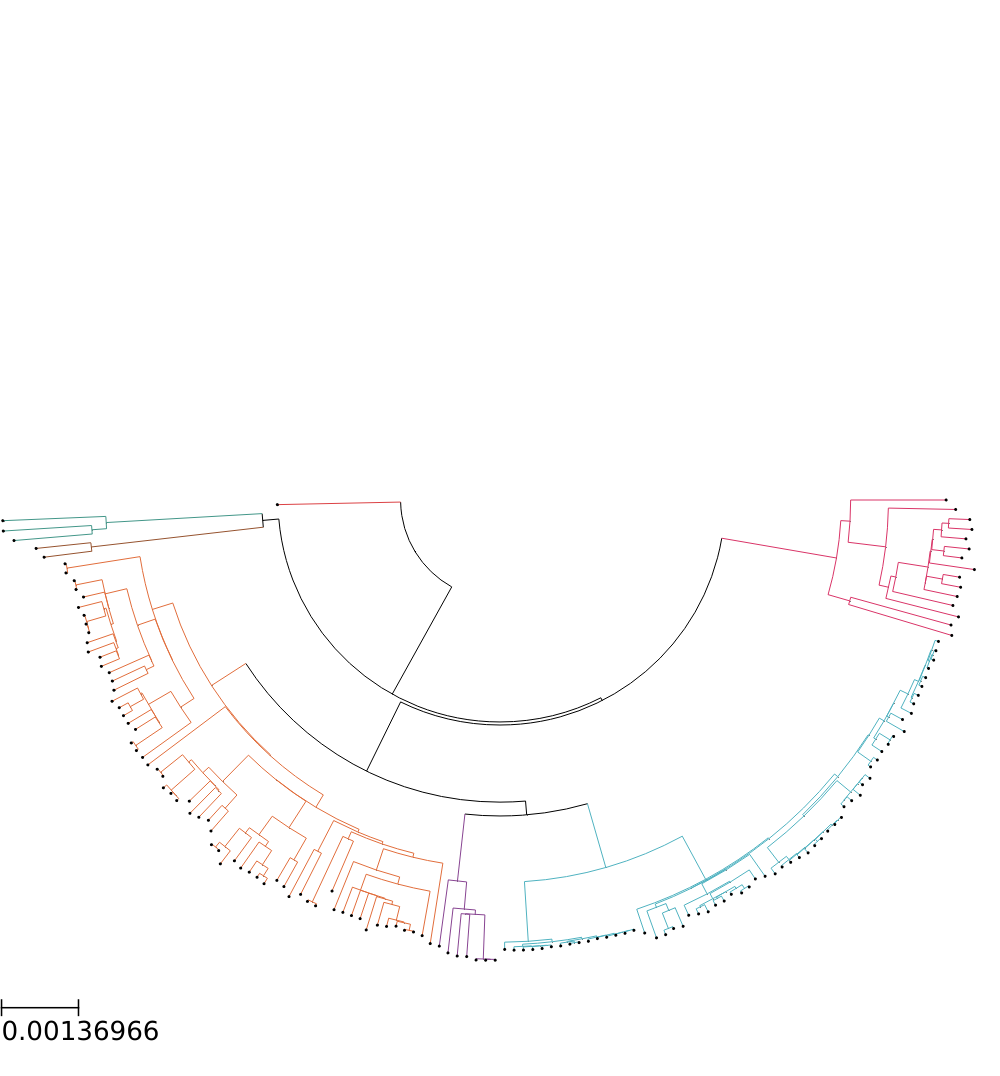

In [35]:
IQ_Tree.render("%%inline", w = 1000, tree_style = ts_IQ_circ)

In [35]:
Y = IQ_Tree.render("Results1_Plots/1.Mtb.151CI.CircPhylo.svg", w = 1000, tree_style = ts_IQ_circ)




In [36]:
Y = IQ_Tree.render("Results1_Plots/1.Mtb.151CI.CircPhylo.png", w = 1000, tree_style = ts_IQ_circ, dpi = 600)  



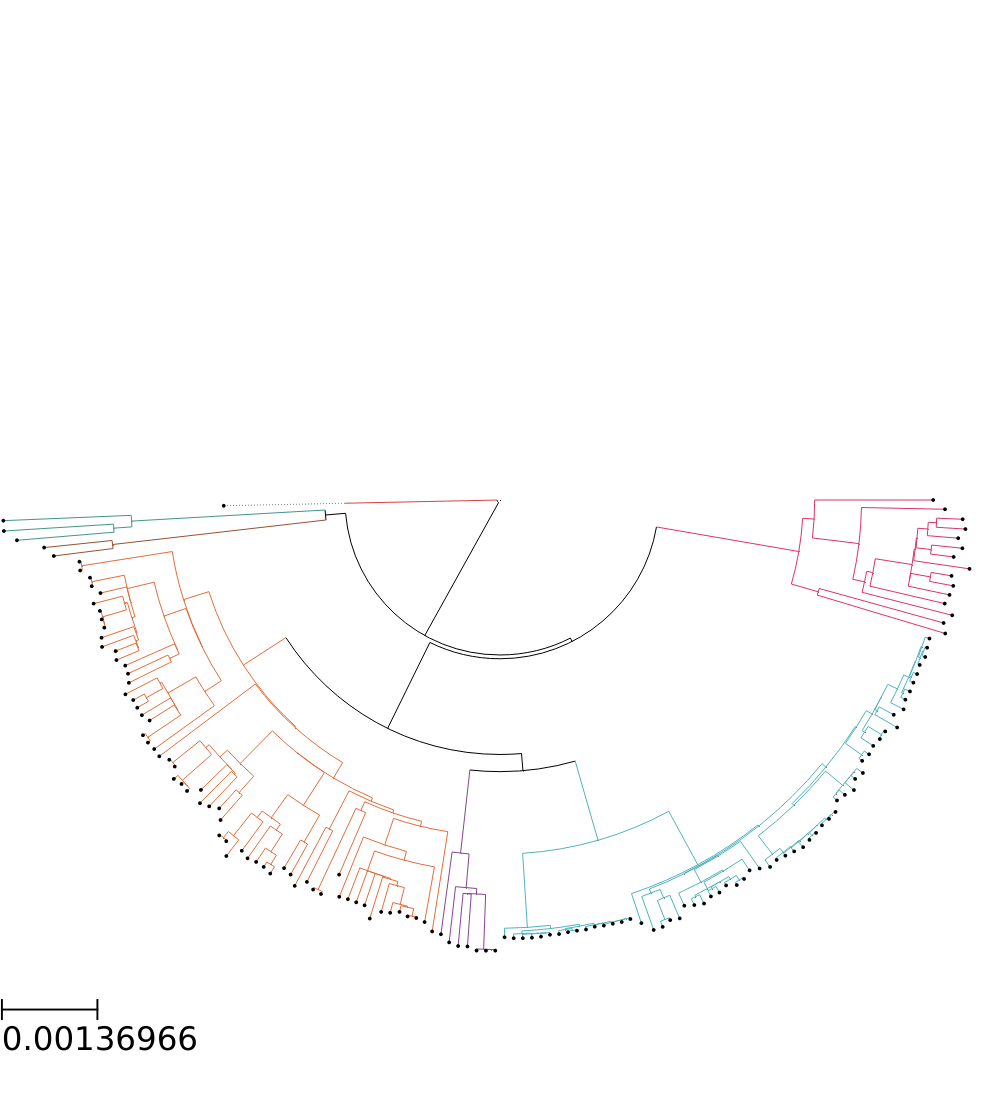

In [37]:
IQ_Tree.render("%%inline", w = 1000, tree_style = ts_IQ_circ)

## Parse SourMASH output files

In [38]:
SourMASH_MainDir = f"{MtbWGA_SMK_Pipeline_OutputDir}/SourMash"

# SourMASH Default Out
SourMASH_AllVsAll_Default_OutDir = f"{SourMASH_MainDir}/CompareAllAsm_Default"

SM_AvA_Default_JS_OUT = f"{SourMASH_AllVsAll_Default_OutDir}/SourMash.Compare.Default.out"
SM_AvA_Default_Labels_TXT = f"{SourMASH_AllVsAll_Default_OutDir}/SourMash.Compare.Default.out.labels.txt"

# SourMASH Scaled Out
SourMASH_AllVsAll_Scaled_OutDir = f"{SourMASH_MainDir}/CompareAllAsm_Scaled1"

SM_AvA_Scaled1_JS_OUT = f"{SourMASH_AllVsAll_Scaled_OutDir}/SourMash.Compare.Scaled1.out"
SM_AvA_Scaled1_Labels_TXT = f"{SourMASH_AllVsAll_Scaled_OutDir}/SourMash.Compare.Scaled1.out.labels.txt"


In [39]:
!ls -l $SourMASH_MainDir/CompareAllAsm_Scaled1

total 672
-rw-rw-r-- 1 mm774 farhat 182536 Nov 22 02:38 SourMash.Compare.Scaled1.out
-rw-rw-r-- 1 mm774 farhat  25132 Nov 22 02:38 SourMash.Compare.Scaled1.out.dendro.pdf
-rw-rw-r-- 1 mm774 farhat   8674 Nov 22 02:37 SourMash.Compare.Scaled1.out.hist.pdf
-rw-rw-r-- 1 mm774 farhat  17203 Nov 22 02:37 SourMash.Compare.Scaled1.out.labels.txt
-rw-rw-r-- 1 mm774 farhat  33602 Nov 22 02:38 SourMash.Compare.Scaled1.out.matrix.pdf


In [40]:
SM_AvA_Labels = pd.read_csv(SM_AvA_Scaled1_Labels_TXT, sep = "\t", header = None)[0].str.split("/").str[-1].str.split(".").str[0]
SM_AvA_Labels.shape

(151,)

In [41]:
SM_AvA_Labels.head(3)

0     N0072
1     N0153
2    TB3113
Name: 0, dtype: object

In [42]:
!cp $SM_AvA_Scaled1_Labels_TXT ./Data

## Parse the Jaccard Simularity of k-mers (k = 31 bp)

In [43]:
AvA_LR_JS_NP = np.load(SM_AvA_Scaled1_JS_OUT)
AvA_LR_JS_DF = pd.DataFrame(AvA_LR_JS_NP)

AvA_LR_JS_DF.columns = SM_AvA_Labels
AvA_LR_JS_DF.index = SM_AvA_Labels


In [44]:
#AvA_LR_JS_DF.head(2)

In [45]:
AvA_LR_JS_DF.loc[["N0072", "N0153",], ["N0072", "N0153",]]

,N0072,N0153
0,,
N0072,1.000000,0.977294
N0153,0.977294,1.000000


In [46]:
AvA_LR_JS_DF.index = AvA_LR_JS_DF.index.rename("SampleID_1")
AvA_LR_JS_DF.columns = AvA_LR_JS_DF.columns.rename("SampleID_2")

LR_JaccSim_Pairwise_DF = AvA_LR_JS_DF.stack().reset_index()

LR_JaccSim_Pairwise_DF.columns = ["SampleID_1", "SampleID_2", "Mash_JS"]
LR_JaccSim_Pairwise_DF.sort_values(["SampleID_1", "SampleID_2"])

LR_JaccSim_Pairwise_DF = LR_JaccSim_Pairwise_DF.query(" SampleID_1 != SampleID_2 ")

LR_JaccSim_Pairwise_DF.shape 

(22650, 3)

In [47]:
LR_JaccSim_Pairwise_DF.head(2)

,SampleID_1,SampleID_2,Mash_JS
1,N0072,N0153,0.977294
2,N0072,TB3113,0.953578


In [48]:
LR_JaccSim_Pairwise_DF.sort_values("Mash_JS", ascending=True).head(4)

,SampleID_1,SampleID_2,Mash_JS
7143,RW-TB008,N0091,0.935922
6993,N0091,RW-TB008,0.935922
6842,N1177,RW-TB008,0.936955
7142,RW-TB008,N1177,0.936955


In [49]:
LR_JaccSim_Pairwise_DF["Mash_JS"].describe()

count    22650.000000
mean         0.969506
std          0.013758
min          0.935922
25%          0.960886
50%          0.967502
75%          0.978211
max          0.999986
Name: Mash_JS, dtype: float64

# Plot the distribution of K-mer JCs between all LR Assemblies

In [50]:
LR_JaccSim_Pairwise_DF["Mash_JS"].describe()

count    22650.000000
mean         0.969506
std          0.013758
min          0.935922
25%          0.960886
50%          0.967502
75%          0.978211
max          0.999986
Name: Mash_JS, dtype: float64

In [51]:
sns.set_context("paper", font_scale=3)

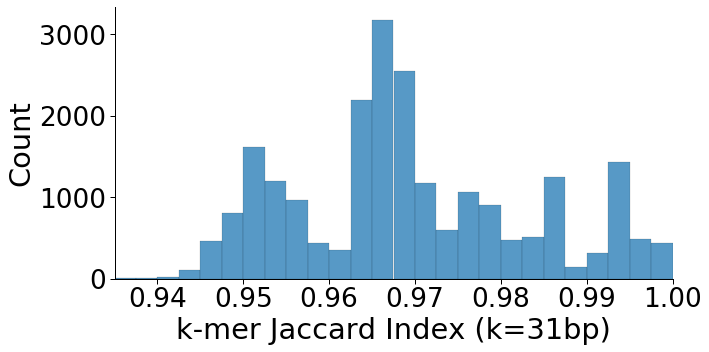

In [52]:
plt.figure(figsize = (10,5))

sns.histplot(LR_JaccSim_Pairwise_DF["Mash_JS"], bins = np.arange(0, 1.05, 0.0025))
sns.despine()

#plt.title("Distr. of pair-wise Jaccard Similarity \n (158 Mtb isolates) ")
plt.xlabel("k-mer Jaccard Index (k=31bp)")

#plt.ylabel("Count")
plt.xlim(0.935, 1.00)
#plt.ylim(0,4000)
#plt.savefig("Results1_Plots/1.KmerJS.Histo.png", dpi = 300)
#plt.savefig("Results1_Plots/1.KmerJS.Histo.svg")

plt.show()


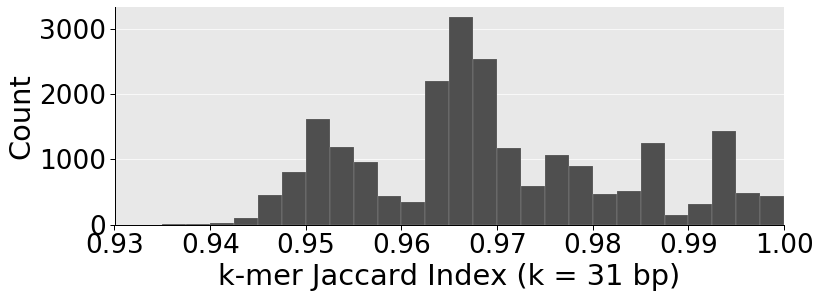

In [101]:
fig, ax1 = plt.subplots(figsize=(12,4))

#sns.set_style(None)
#sns.set()

ax1.grid(axis='y', zorder=0, linewidth=.7, color = "white" )
sns.set_style(rc={'axes.facecolor': '#E8E8E8'})

sns.histplot(LR_JaccSim_Pairwise_DF["Mash_JS"], bins = np.arange(0, 1.05, 0.0025), edgecolor='white', color = '#4F4F4F', alpha = 1, ax = ax1, zorder = 3)
             # hist_kws={"rwidth":0.75,'edgecolor':'none', 'alpha':1.0})
sns.despine()

#ax1.set_axisbelow(True)


#plt.title("Distr. of pair-wise predicted ANI \n (158 Mtb isolates) ")

plt.xlabel("k-mer Jaccard Index (k = 31 bp)")
plt.ylabel("Count")
plt.xlim(0.93, 1.00)

ticks_ax_limewidth = 2

#ax1.tick_params('both', length=15, width=ticks_ax_limewidth, which='major')

#for axis in ['bottom','left']:
#    ax1.spines[axis].set_linewidth(ticks_ax_limewidth)

#plt.tight_layout()

#plt.ylim(0,4000)
plt.savefig("Results1_Plots/1.KmerJS.Histo.png", dpi = 300)
plt.savefig("Results1_Plots/1.KmerJS.Histo.svg")

plt.show()


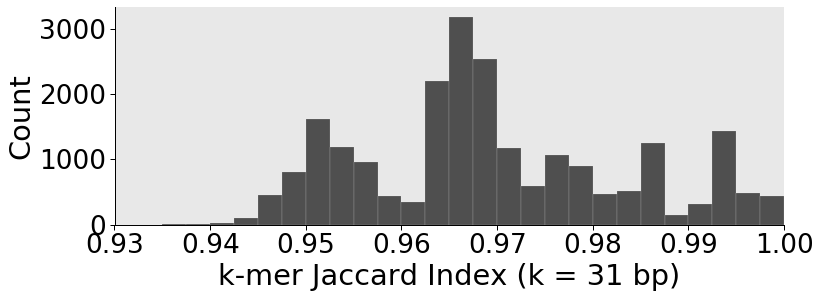

In [103]:
fig, ax1 = plt.subplots(figsize=(12,4))


sns.histplot(LR_JaccSim_Pairwise_DF["Mash_JS"],
             bins = np.arange(0, 1.05, 0.0025),
             edgecolor='white',
             color = '#4F4F4F',
             alpha = 1, ax = ax1, zorder = 3)

sns.despine()

plt.xlabel("k-mer Jaccard Index (k = 31 bp)")
plt.ylabel("Count")
plt.xlim(0.93, 1.00)

plt.savefig("Results1_Plots/1.KmerJS.Histo.png", dpi = 300)
plt.savefig("Results1_Plots/1.KmerJS.Histo.svg")

plt.show()


In [54]:
LR_JaccSim_Pairwise_DF.query("Mash_JS == 1")

,SampleID_1,SampleID_2,Mash_JS


## Make a HeatMap of Jaccard Simularity between assemblies

In [55]:
#OrderOfSampleIDs_Phylo

In [56]:
# Reorder the matrix of Jaccard Sim between all assemblies to fit phylogeny

AvA_LR_JS_Ordered_DF = AvA_LR_JS_DF.loc[OrderOfSampleIDs_Phylo, OrderOfSampleIDs_Phylo]
AvA_LR_JS_Ordered_DF.shape

(151, 151)

#### Make sample lineage & color mapping

/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1340.1764705882351, '')

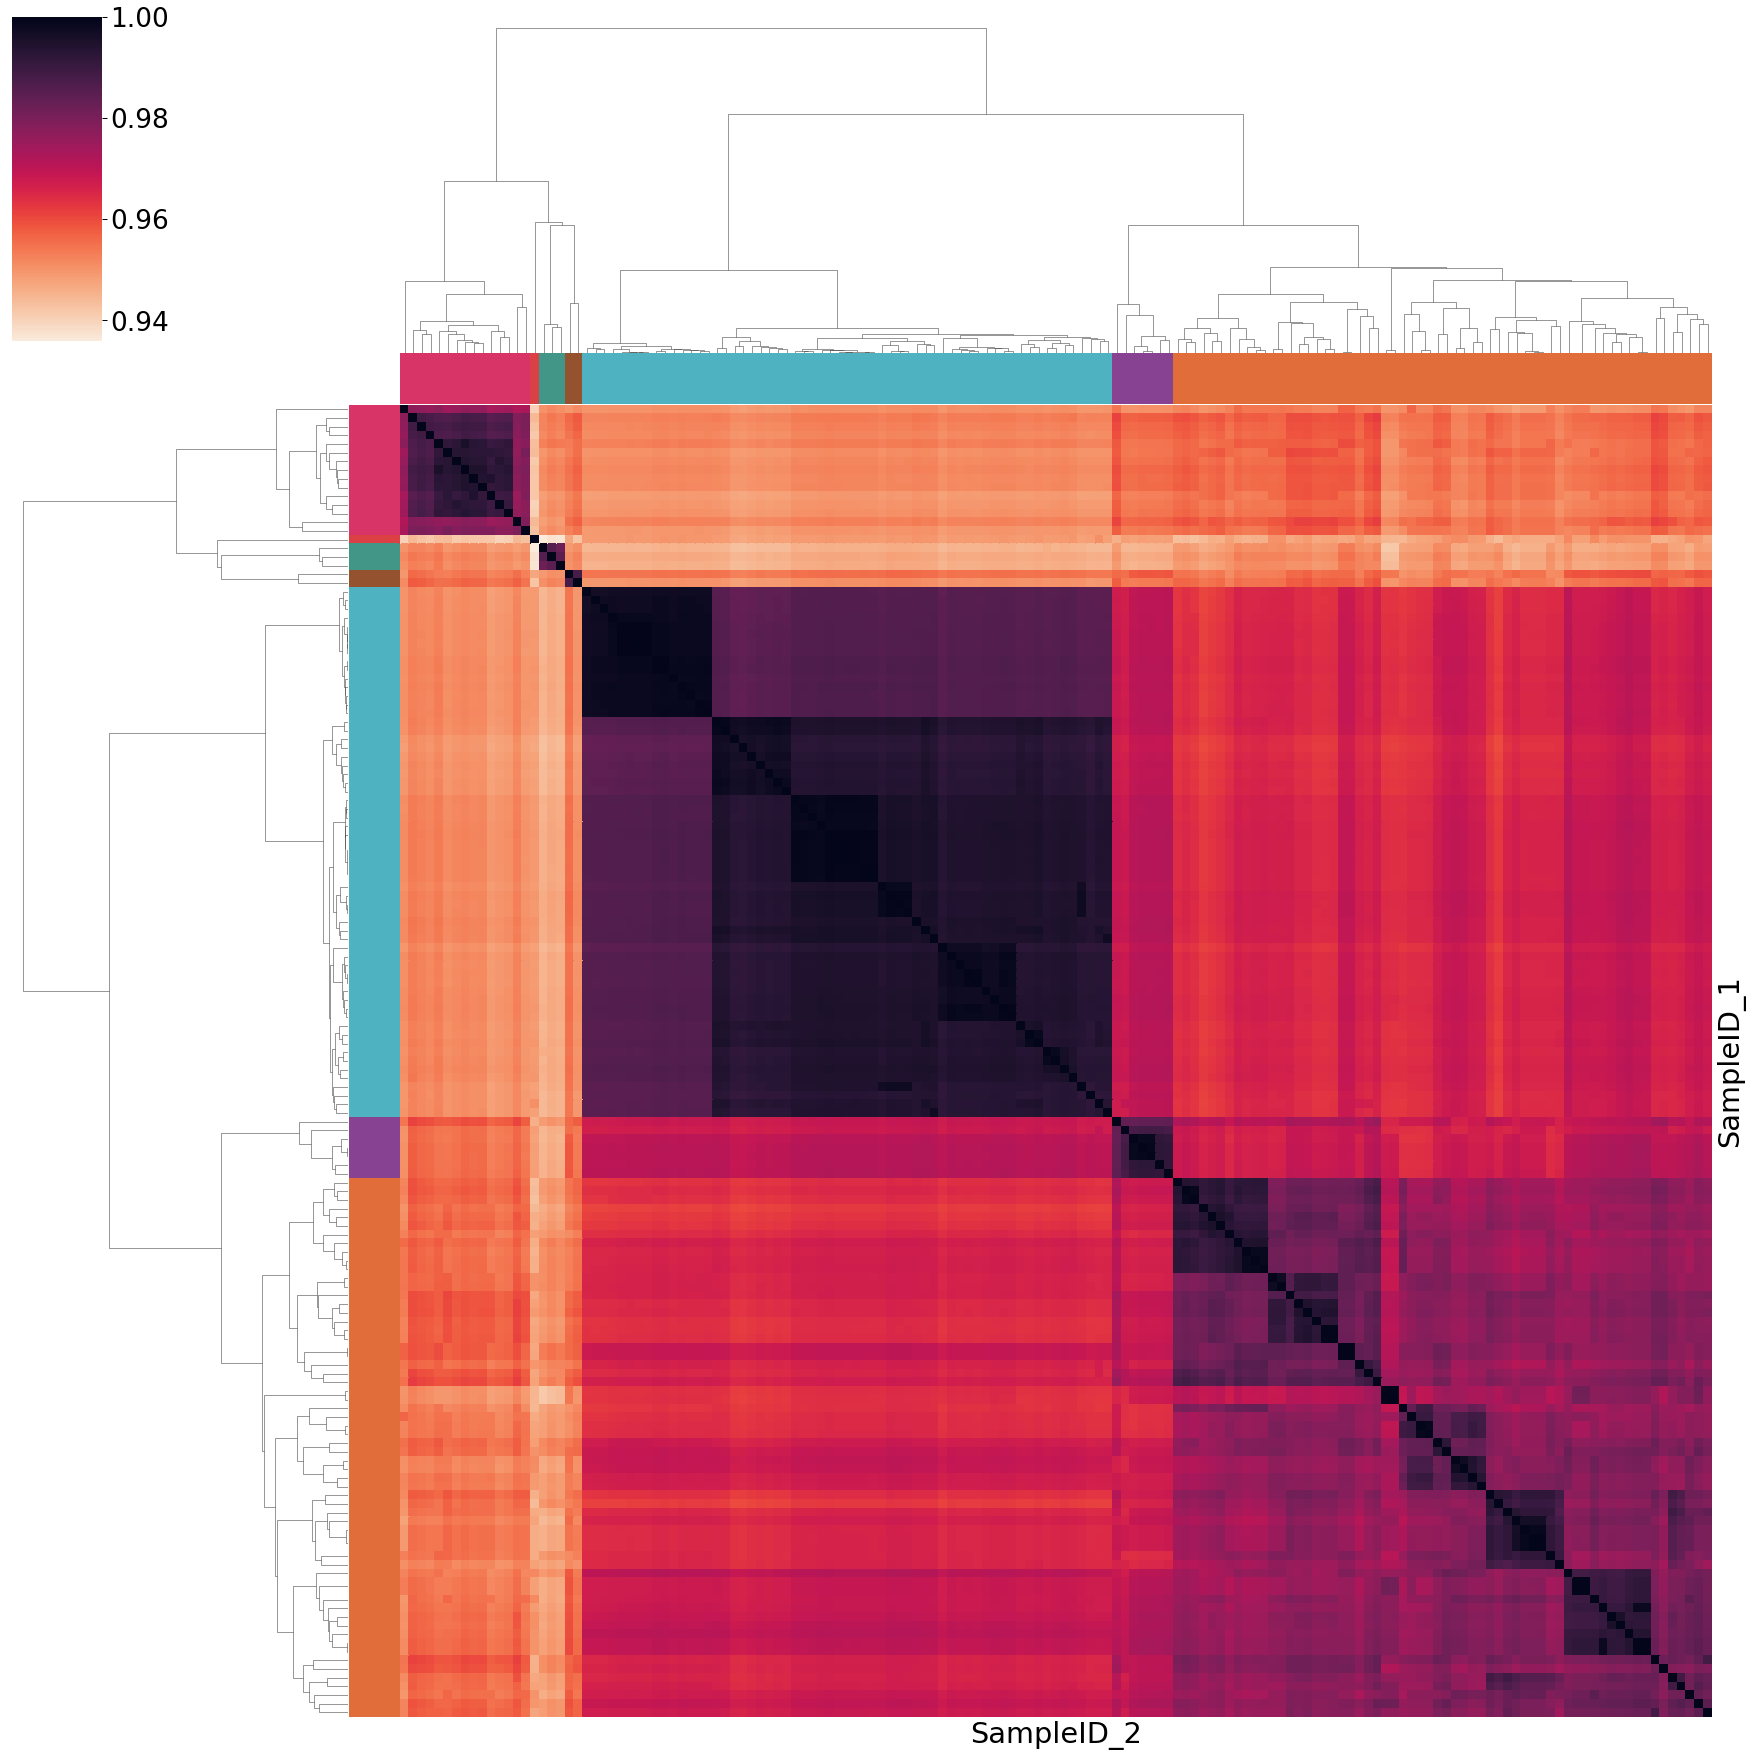

In [57]:
fig_dims = (25, 25)

row_colors = [sample_colors.get(sample, "black") for sample in AvA_LR_JS_Ordered_DF.index]
col_colors = [sample_colors.get(sample, "black") for sample in AvA_LR_JS_Ordered_DF.columns]

clustermap_plot = sns.clustermap(AvA_LR_JS_Ordered_DF, 
                                 row_colors=row_colors,
                                 col_colors=col_colors,
                                 figsize=fig_dims, 
                                 row_cluster=True, col_cluster=True,
                                 #cbar_pos = None,
                                 cmap='rocket_r',
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False ) #vmin = 0.93 )

plt.ylabel("")
plt.xlabel("")

#plt.savefig("Results1_Plots/1.KmerJS.Clustermap.NoLabels.png", dpi = 300)
#plt.savefig("Results1_Plots/1.KmerJS.Clustermap.NoLabels.svg")


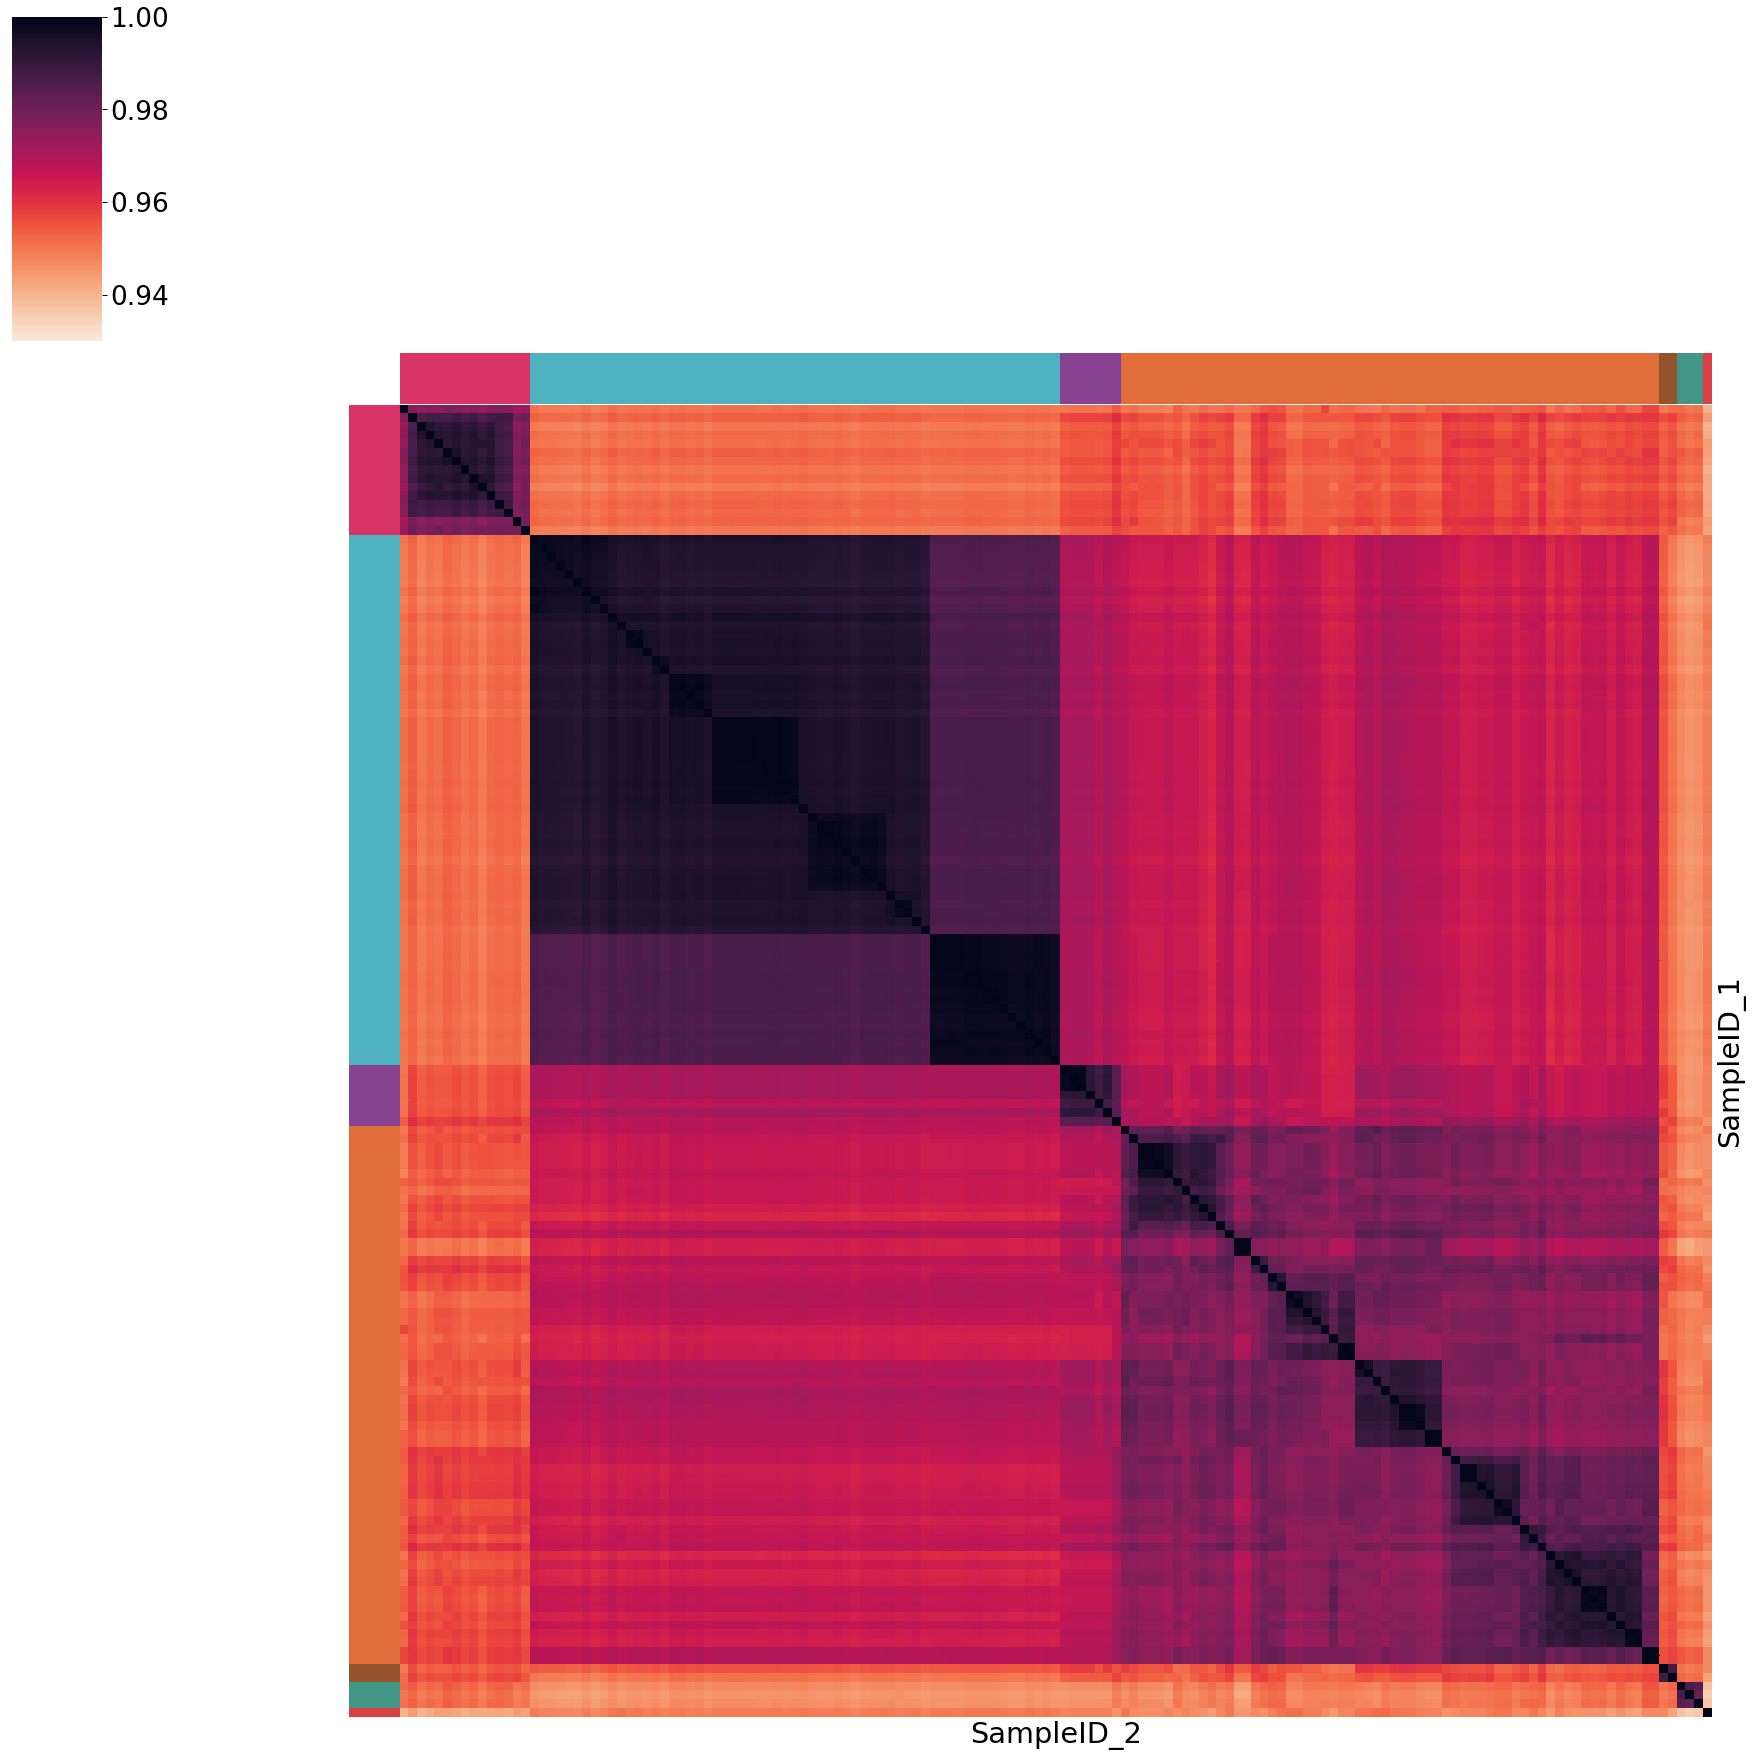

In [94]:
fig_dims = (25, 25)

row_colors = [sample_colors.get(sample, "black") for sample in AvA_LR_JS_Ordered_DF.index]
col_colors = [sample_colors.get(sample, "black") for sample in AvA_LR_JS_Ordered_DF.columns]

clustermap_plot = sns.clustermap(AvA_LR_JS_Ordered_DF, 
                                 row_colors=row_colors,
                                 col_colors=col_colors,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cmap='rocket_r',
                                 #cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False, vmin = 0.93 )

plt.ylabel("")
plt.xlabel("")

plt.savefig("Results1_Plots/1.KmerJS.heatmap.NoLabels.png", dpi = 300)
plt.savefig("Results1_Plots/1.KmerJS.heatmap.NoLabels.svg")


In [59]:
# fig_dims = (25, 25)

# row_colors = [sample_colors.get(sample, "black") for sample in AvA_LR_JS_Ordered_DF.index]
# col_colors = [sample_colors.get(sample, "black") for sample in AvA_LR_JS_Ordered_DF.columns]

# clustermap_plot = sns.clustermap(AvA_LR_JS_Ordered_DF, 
#                                  row_colors=row_colors,
#                                  col_colors=col_colors,
#                                  figsize=fig_dims, 
#                                  row_cluster=False, col_cluster=False,
#                                  cmap='Blues',
#                                  #cbar_pos = None,
#                                  linewidths=0,
#                                  xticklabels=False,
#                                  yticklabels=False ) #vmin = 0.93 )

# plt.ylabel("")
# plt.xlabel("")
# plt.show()

In [60]:
# fig_dims = (25, 25)

# row_colors = [sample_colors.get(sample, "black") for sample in AvA_LR_JS_Ordered_DF.index]
# col_colors = [sample_colors.get(sample, "black") for sample in AvA_LR_JS_Ordered_DF.columns]

# clustermap_plot = sns.clustermap(AvA_LR_JS_Ordered_DF, 
#                                  row_colors=row_colors,
#                                  col_colors=col_colors,
#                                  figsize=fig_dims, 
#                                  row_cluster=True, col_cluster=True,
#                                  cmap='Blues',
#                                  #cbar_pos = None,
#                                  linewidths=0,
#                                  xticklabels=False,
#                                  yticklabels=False ) #vmin = 0.93 )

# plt.ylabel("")
# plt.xlabel("")
# plt.show()

# Parse FastANI output (All vs All)

In [61]:
#!ls -lah $MtbWGA_SMK_Pipeline_OutputDir

In [62]:
FastANI_MainDir = f"{MtbWGA_SMK_Pipeline_OutputDir}/FastANI"

LR_Asm_AllVsAll_OutDir = f"{FastANI_MainDir}/FastANI_LRAsm"

AvA_158CI_FastANI_LRAsm_TXT = f"{LR_Asm_AllVsAll_OutDir}/FastANI.AllVsAll.LRAsm.txt"

AvA_158CIWiH37Rv_FastANI_LRAsm_TXT = f"{LR_Asm_AllVsAll_OutDir}/FastANI.AllVsAll.WiH37Rv.LRAsm.txt"     



In [63]:
#!cp $AvA_158CI_FastANI_LRAsm_TXT ./Data

In [64]:
!ls -lah $LR_Asm_AllVsAll_OutDir

total 8.3M
drwxrwsr-x 2 mm774 farhat   96 Nov 22 14:04 .
drwxrwsr-x 4 mm774 farhat  102 Nov 22 12:05 ..
-rw-rw-r-- 1 mm774 farhat 7.1M Nov 22 13:55 FastANI.AllVsAll.LRAsm.txt
-rw-rw-r-- 1 mm774 farhat 7.2M Nov 22 14:05 FastANI.AllVsAll.WiH37Rv.LRAsm.txt


In [65]:
FANI_AvA_DF = pd.read_csv(AvA_158CI_FastANI_LRAsm_TXT, sep = "\t", header = None)
FANI_AvA_DF.columns = ["Query", "Ref", "ANI", "Bidirect_FragMap", "Total_Query_Frags"]

# Trim down full file path to JUST the SampleID (For Query and Reference genomes)
FANI_AvA_DF["Query"] = FANI_AvA_DF["Query"].str.split("/").str[-1].str.split(".").str[0]
FANI_AvA_DF["Ref"] = FANI_AvA_DF["Ref"].str.split("/").str[-1].str.split(".").str[0]

FANI_AvA_DF.shape

(22801, 5)

In [66]:
FANI_AvA_DF.head(2)

,Query,Ref,ANI,Bidirect_FragMap,Total_Query_Frags
0,N0072,N0072,100.0000,1473,1473
1,N0072,mada_118,99.9727,1470,1473


In [67]:
FANI_AvA_NoSelf_DF = FANI_AvA_DF.query(" Query != Ref ")
FANI_AvA_NoSelf_DF.shape

(22650, 5)

In [68]:
FANI_AvA_NoSelf_DF["ANI"].describe()

count    22650.000000
mean        99.912547
std          0.036683
min         99.805100
25%         99.890500
50%         99.907400
75%         99.936900
max        100.000000
Name: ANI, dtype: float64

In [69]:
FANI_AvA_NoSelf_DF.query("ANI == 100")

,Query,Ref,ANI,Bidirect_FragMap,Total_Query_Frags
22349,S0123-01,S0262-02,100.0,1467,1467
22651,S0262-02,S0123-01,100.0,1467,1467


In [70]:
FANI_AvA_NoSelf_DF.head(2)

,Query,Ref,ANI,Bidirect_FragMap,Total_Query_Frags
1,N0072,mada_118,99.9727,1470,1473
2,N0072,mada_1-51,99.9712,1472,1473


In [71]:
#FANI_AvA_Ordered_DF = FANI_AvA_DF.loc[OrderOfSampleIDs_Phylo, OrderOfSampleIDs_Phylo]
#FANI_AvA_Ordered_DF.shape

In [72]:
FANI_AvA_NoSelf_DF.sort_values("ANI", ascending=True).head(15)

,Query,Ref,ANI,Bidirect_FragMap,Total_Query_Frags
11324,mada_122,9050-05,99.8051,1463,1474
11323,mada_122,TB3396,99.8060,1463,1474
11322,mada_122,TB3091,99.8069,1463,1474
10418,mada_1-36,S0085-01,99.8107,1460,1473
11321,mada_122,S0070-08,99.8120,1462,1474
11320,mada_122,N0145,99.8141,1458,1474
10417,mada_1-36,9050-05,99.8148,1462,1473
11777,R23887,M0003941_3,99.8148,1456,1472
10870,mada_1-44,R30078,99.8154,1463,1473
10871,mada_1-44,R28012,99.8154,1463,1473


In [73]:
ID_To_SubLineage_Dict["mada_122"]

'lineage1.1.2'

In [74]:
ID_To_SubLineage_Dict["9050-05"]

'lineage2.2.1'

In [75]:
ID_To_SubLineage_Dict["mada_1-44"]

'lineage1.1.2'

In [76]:
ID_To_SubLineage_Dict["R30078"]

'lineage2.2.1'

# Plot the distribution of pairwise predicted ANIs 

In [77]:
FANI_AvA_NoSelf_DF["ANI"].describe()

count    22650.000000
mean        99.912547
std          0.036683
min         99.805100
25%         99.890500
50%         99.907400
75%         99.936900
max        100.000000
Name: ANI, dtype: float64

In [78]:
sns.set_context("paper", font_scale=3)


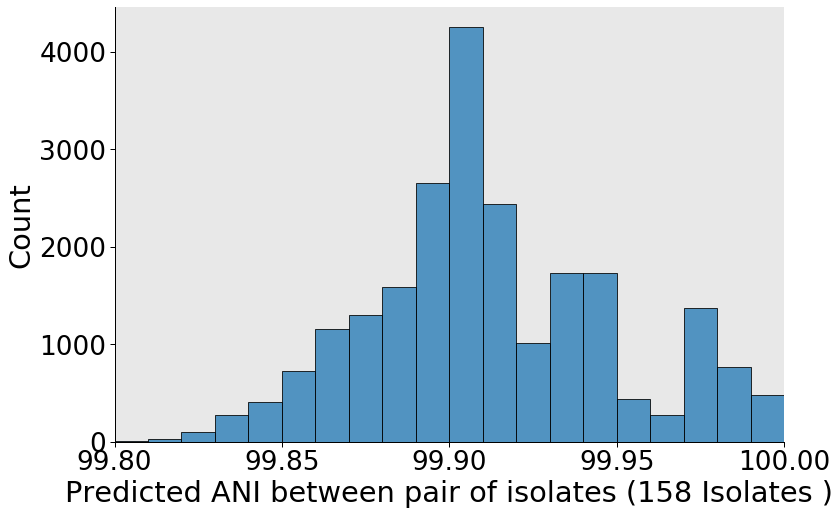

In [79]:
plt.figure(figsize = (12,8))

sns.histplot(FANI_AvA_NoSelf_DF["ANI"], bins = np.arange(99.5, 100.01, 0.01))
sns.despine()

#plt.title("Distr. of pair-wise predicted ANI \n (158 Mtb isolates) ")

plt.xlabel("Predicted ANI between pair of isolates (158 Isolates )")
plt.ylabel("Count")
plt.xlim(99.8, 100)
#plt.ylim(0,4000)
plt.show()

In [80]:
FANI_AvA_NoSelf_DF["ANI"].describe()

count    22650.000000
mean        99.912547
std          0.036683
min         99.805100
25%         99.890500
50%         99.907400
75%         99.936900
max        100.000000
Name: ANI, dtype: float64

In [81]:
sns.set_context("paper", font_scale=3)


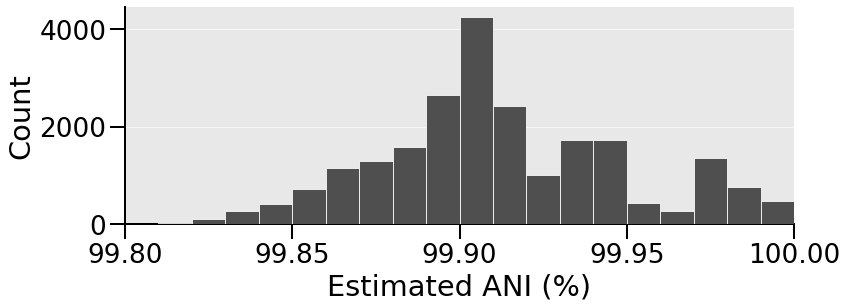

In [82]:
fig, ax1 = plt.subplots(figsize=(12,4))

#sns.set_style(None)
#sns.set()

ax1.grid(axis='y', zorder=0, linewidth=.7, color = "white" )
sns.set_style(rc={'axes.facecolor': '#E8E8E8'})

sns.histplot(FANI_AvA_NoSelf_DF["ANI"], bins = np.arange(99.8, 100.01, 0.01), edgecolor='white', color = '#4F4F4F', alpha = 1, ax = ax1, zorder = 3)
             # hist_kws={"rwidth":0.75,'edgecolor':'none', 'alpha':1.0})
sns.despine()

#ax1.set_axisbelow(True)


#plt.title("Distr. of pair-wise predicted ANI \n (158 Mtb isolates) ")

plt.xlabel("Estimated ANI (%)")
plt.ylabel("Count")
plt.xlim(99.8, 100)

ticks_ax_limewidth = 2

ax1.tick_params('both', length=15, width=ticks_ax_limewidth, which='major')

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(ticks_ax_limewidth)

#plt.ylim(0,4000)
plt.savefig("Results1_Plots/1.ANI.Histo.png", dpi = 300)
plt.savefig("Results1_Plots/1.ANI.Histo.svg")

plt.show()


In [83]:
FANI_AvA_DF.head()

,Query,Ref,ANI,Bidirect_FragMap,Total_Query_Frags
0,N0072,N0072,100.0000,1473,1473
1,N0072,mada_118,99.9727,1470,1473
2,N0072,mada_1-51,99.9712,1472,1473
3,N0072,mada_122,99.9709,1469,1473
4,N0072,mada_1-1,99.9703,1469,1473


In [84]:
FANI_AvA_DF["ANI"].describe()

count    22801.000000
mean        99.913126
std          0.037243
min         99.805100
25%         99.890700
50%         99.907600
75%         99.937500
max        100.000000
Name: ANI, dtype: float64

In [85]:
FANI_AvA_Pivot = FANI_AvA_DF.pivot(index='Query', columns='Ref', values='ANI')
FANI_AvA_Pivot.shape

(151, 151)

In [86]:
FANI_AvA_Pivot.head(2)

Ref,01_R1134,01_R1430,02_R0894,02_R1179,02_R1708,02_R1896,18_0621851,3003-06,4549-04,696-05,...,mada_128,mada_129,mada_139,mada_151,mada_2-1,mada_2-25,mada_2-31,mada_2-42,mada_2-46,mada_2-53
Query,,,,,,,,,,,,,,,,,,,,,
01_R1134,100.0000,99.943,99.9268,99.9448,99.9326,99.9490,99.9098,99.9098,99.9052,99.9069,...,99.9516,99.9301,99.9265,99.9211,99.9482,99.9422,99.9409,99.9025,99.8829,99.9351
01_R1430,99.9434,100.000,99.9185,99.9294,99.9328,99.9557,99.9081,99.9060,99.9008,99.9058,...,99.9322,99.9316,99.9221,99.9317,99.9281,99.9608,99.9394,99.9035,99.8889,99.9327


In [87]:

FANI_AvA_Pivot_Ordered = FANI_AvA_Pivot.loc[OrderOfSampleIDs_Phylo, OrderOfSampleIDs_Phylo]
FANI_AvA_Pivot_Ordered.shape

(151, 151)

In [88]:
# fig, ax1 = plt.subplots(figsize=(30,30))

# sns.heatmap(FANI_AvA_Pivot_Ordered, vmin = 99.7, ax = ax1)

# # https://github.com/mwaskom/seaborn/issues/1773
# b, t = plt.ylim() # discover the values for bottom and top
# b += 0.5 # Add 0.5 to the bottom
# t -= 0.5 # Subtract 0.5 from the top
# plt.ylim(b, t) # update the ylim(bottom, top) values
# plt.show() 

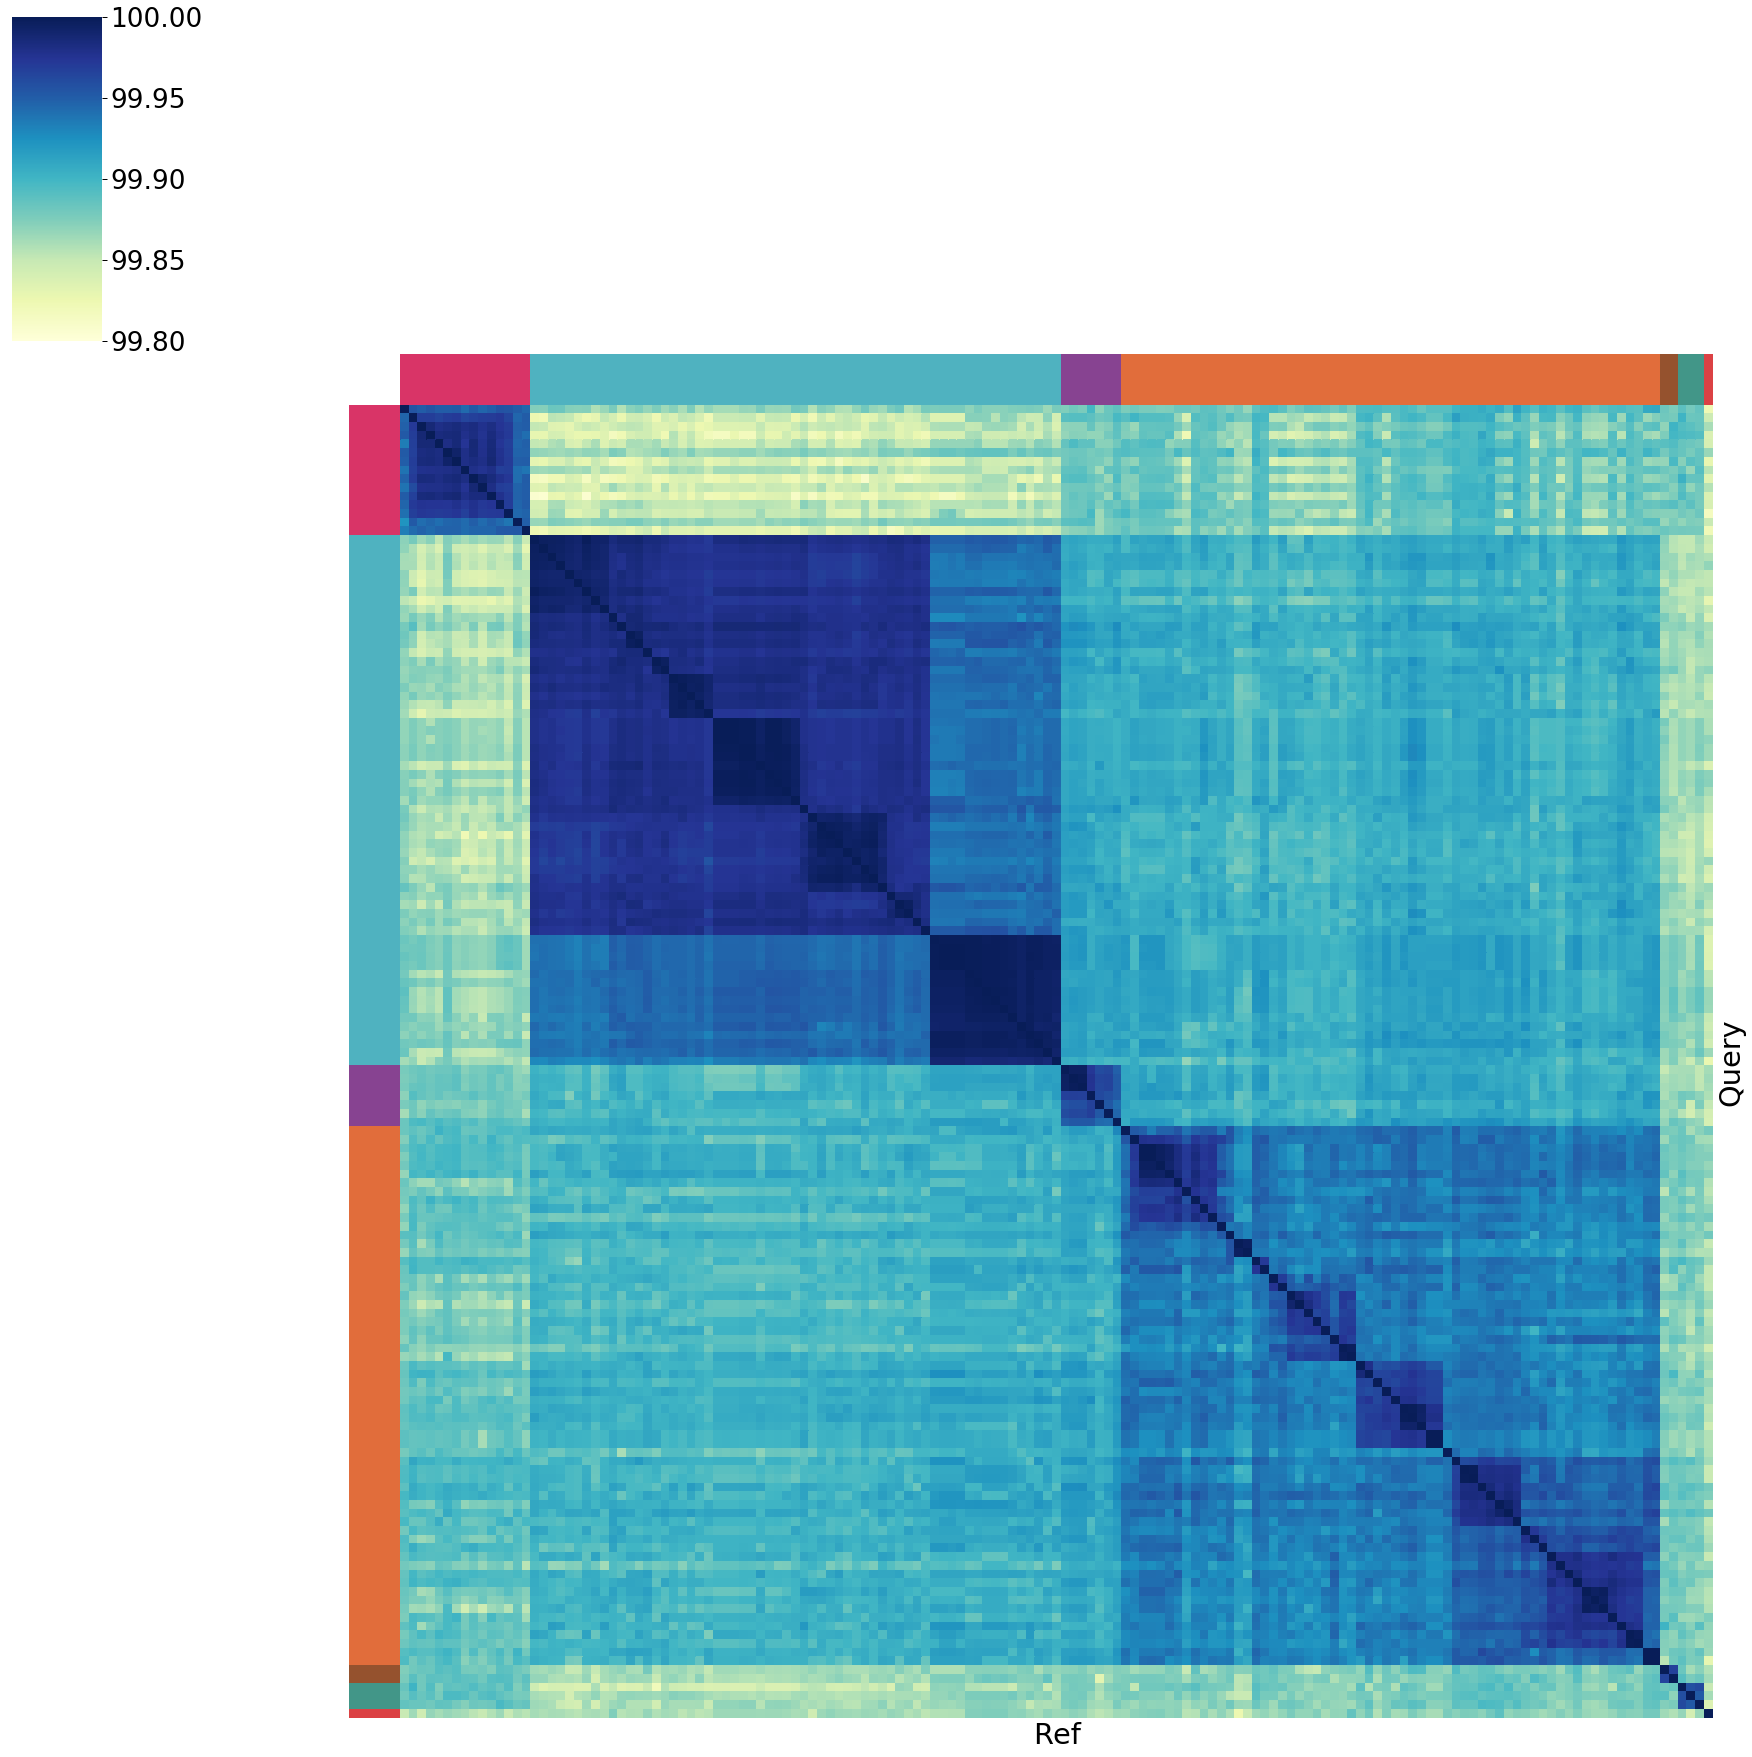

In [89]:
fig_dims = (25, 25)

row_colors = [sample_colors.get(sample, "black") for sample in FANI_AvA_Pivot_Ordered.index]
col_colors = [sample_colors.get(sample, "black") for sample in FANI_AvA_Pivot_Ordered.columns]

g = clustermap_plot = sns.clustermap(FANI_AvA_Pivot_Ordered, 
                                 row_colors=row_colors,
                                 col_colors=col_colors,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 #cbar_pos = None,
                                 cmap='YlGnBu',
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False, vmin = 99.8 )


plt.ylabel("")
plt.xlabel("")

#plt.savefig("Results1_Plots/1.ANI.heatmap.NoLabels.png", dpi = 300)
#plt.savefig("Results1_Plots/1.ANI.heatmap.NoLabels.svg")

plt.show()

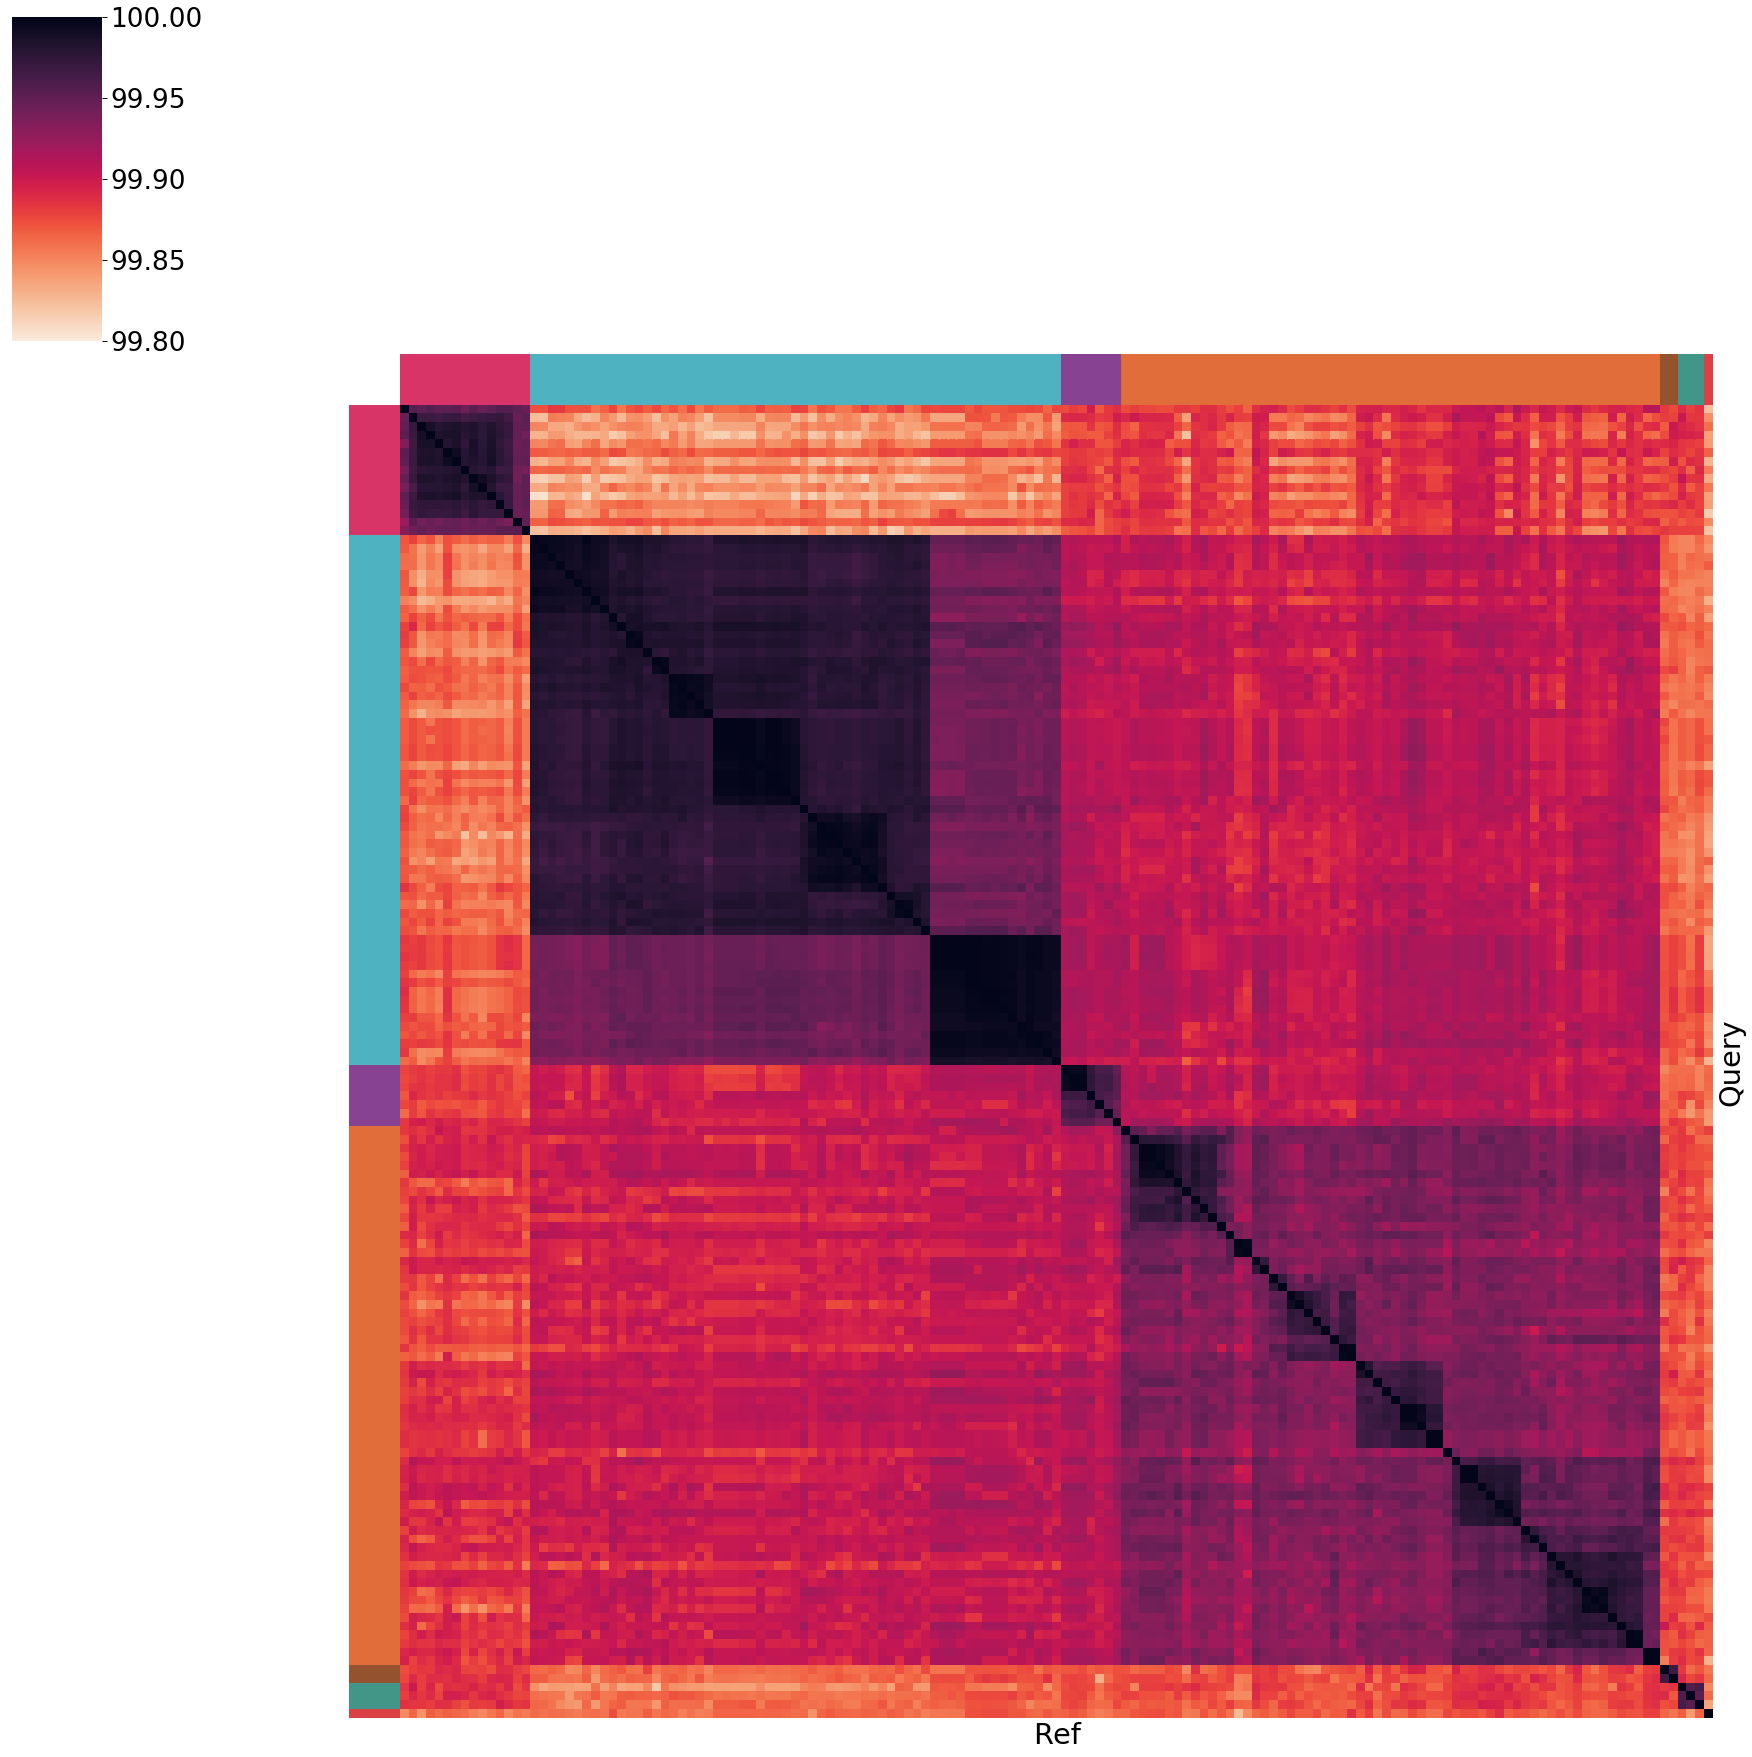

In [90]:
fig_dims = (25, 25)

row_colors = [sample_colors.get(sample, "black") for sample in FANI_AvA_Pivot_Ordered.index]
col_colors = [sample_colors.get(sample, "black") for sample in FANI_AvA_Pivot_Ordered.columns]

g = clustermap_plot = sns.clustermap(FANI_AvA_Pivot_Ordered, 
                                 row_colors=row_colors,
                                 col_colors=col_colors,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 #cbar_pos = None,
                                 cmap='rocket_r',
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False, vmin = 99.8 )


plt.ylabel("")
plt.xlabel("")

plt.savefig("Results1_Plots/1.ANI.heatmap.NoLabels.png", dpi = 300)
plt.savefig("Results1_Plots/1.ANI.heatmap.NoLabels.svg")

plt.show()

In [96]:
# fig_dims = (25, 25)

# row_colors = [sample_colors.get(sample, "black") for sample in FANI_AvA_Pivot_Ordered.index]
# col_colors = [sample_colors.get(sample, "black") for sample in FANI_AvA_Pivot_Ordered.columns]

# g = clustermap_plot = sns.clustermap(FANI_AvA_Pivot_Ordered, 
#                                  row_colors=row_colors,
#                                  col_colors=col_colors,
#                                  figsize=fig_dims, 
#                                  row_cluster=False, col_cluster=False,
#                                  #cbar_pos = None,
#                                  cmap='blues',
#                                  linewidths=0,
#                                  xticklabels=False,
#                                  yticklabels=False, vmin = 99.8 )


# plt.ylabel("")
# plt.xlabel("")

# plt.show()

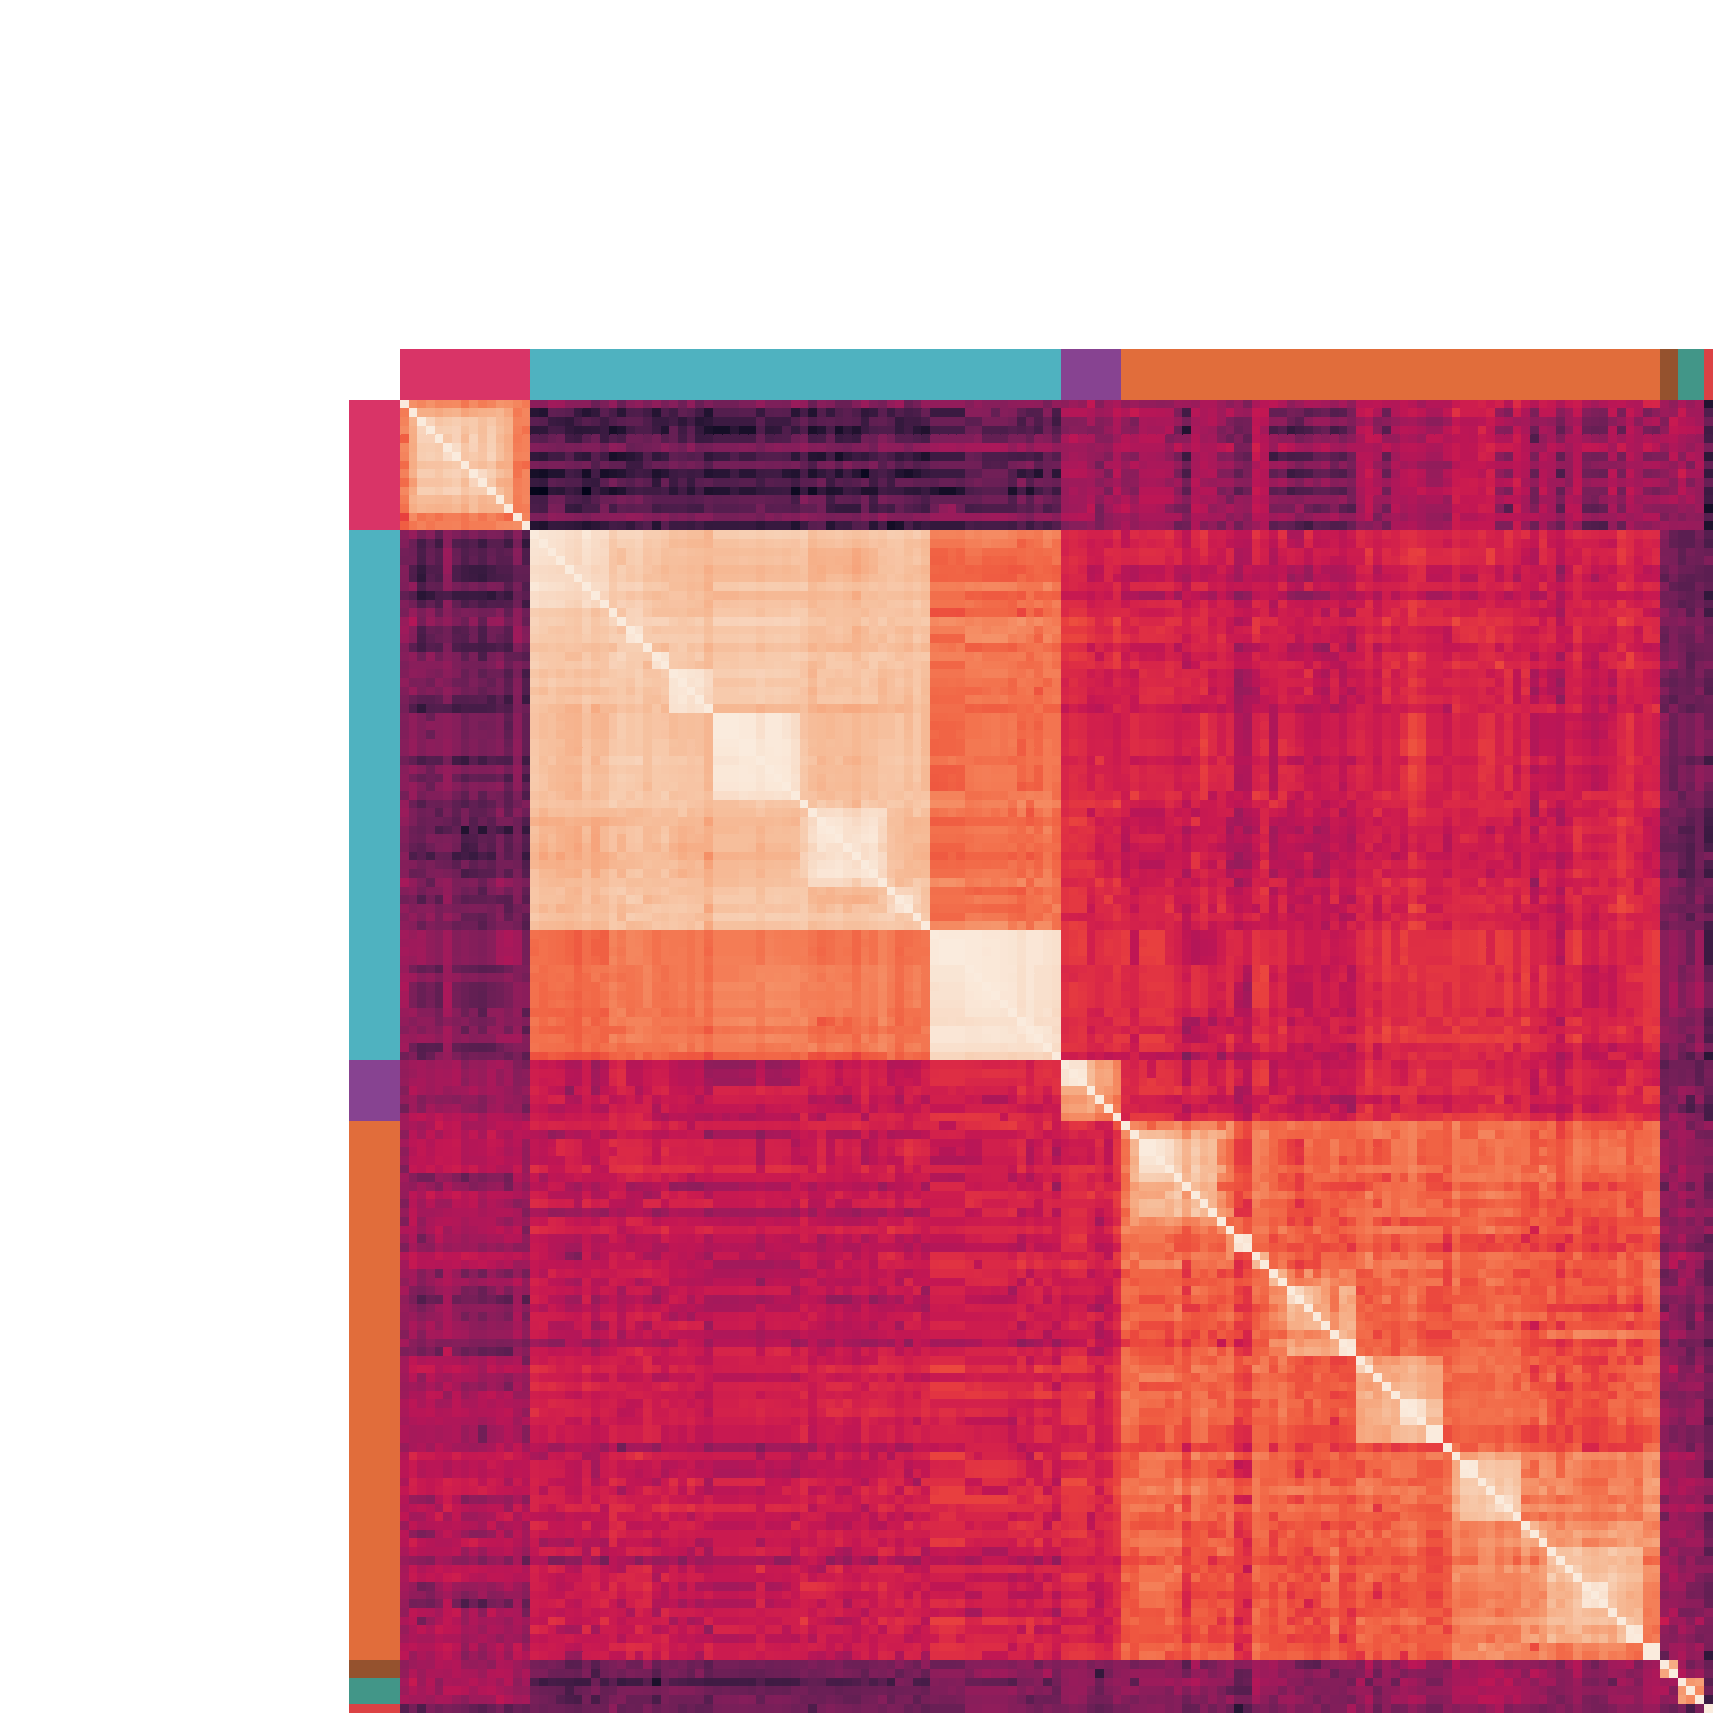

In [97]:
fig_dims = (25, 25)

row_colors = [sample_colors.get(sample, "black") for sample in FANI_AvA_Pivot_Ordered.index]
col_colors = [sample_colors.get(sample, "black") for sample in FANI_AvA_Pivot_Ordered.columns]

g = clustermap_plot = sns.clustermap(FANI_AvA_Pivot_Ordered, 
                                 row_colors=row_colors,
                                 col_colors=col_colors,
                                 figsize=fig_dims, 
                                 row_cluster=False, col_cluster=False,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False, ) #vmin = 0.94 )


plt.ylabel("")
plt.xlabel("")

plt.show()

/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


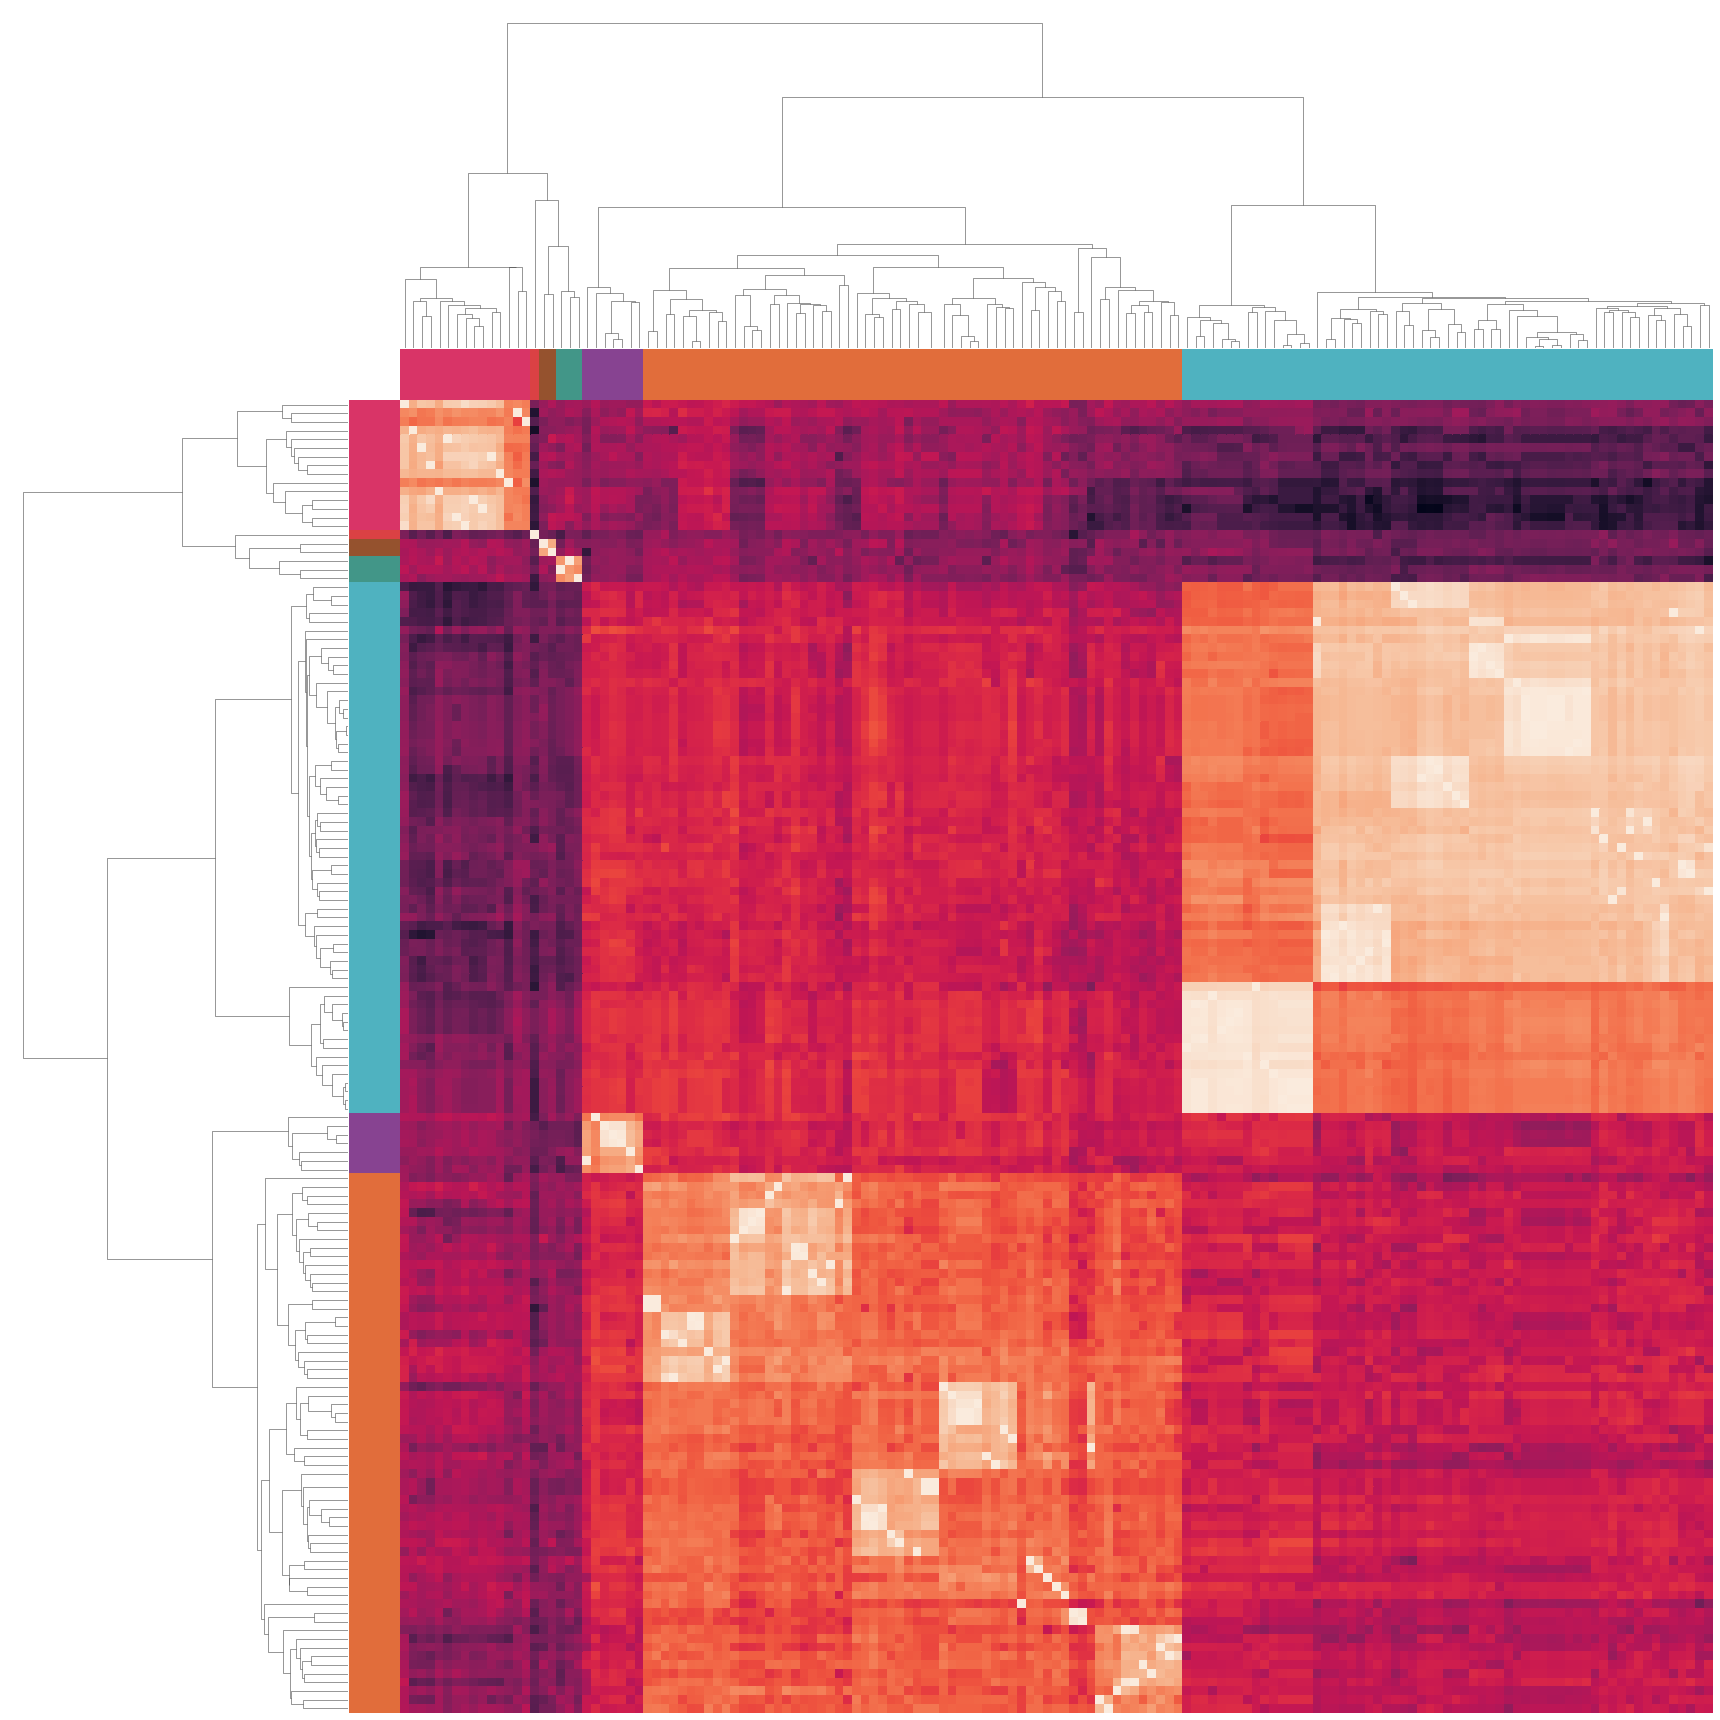

In [98]:
fig_dims = (25, 25)

row_colors = [sample_colors.get(sample, "black") for sample in FANI_AvA_Pivot_Ordered.index]
col_colors = [sample_colors.get(sample, "black") for sample in FANI_AvA_Pivot_Ordered.columns]

g = clustermap_plot = sns.clustermap(FANI_AvA_Pivot_Ordered, 
                                 row_colors=row_colors,
                                 col_colors=col_colors,
                                 figsize=fig_dims, 
                                 row_cluster=True, col_cluster=True,
                                 cbar_pos = None,
                                 linewidths=0,
                                 xticklabels=False,
                                 yticklabels=False, ) #vmin = 0.94 )


plt.ylabel("")
plt.xlabel("")

plt.show()